# EDA

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import time
from time import mktime
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import patsy
from patsy import dmatrices
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO
import cPickle

import statsmodels.api as sm
import folium
from pandas import *
from folium.map import Icon, Marker, Popup
import pickle
from folium.plugins import MarkerCluster

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [32]:
## creating a feature that will take in the column 'TIME' and pop off the last three values and will leave just the hour
## so that I can create the next feature: 'time_segment'

def pop(col):
    NEW_TIME = []
    for i in col:
        NEW_TIME.append(i[:-3])
    return NEW_TIME

## creating a 'time_segment' feature so that I can identify in which blocks of time throughout the day the most amount 
## of crashes take place.

def time_segment(col):
    time_segment = []
    for i in col:
        if (i >= 0) & (i <= 6):
            time_segment.append('early_morning')
        elif (i > 6) & (i <= 12):
            time_segment.append('mid-morning')
        elif (i > 12) & (i <= 15):
            time_segment.append('afternoon')
        elif (i > 15) & (i <= 19):
            time_segment.append('evening')
        elif (i > 19) & (i<=24):
            time_segment.append('late-night')
        else:
            time_segment.append('NA')
    return time_segment

## making a 

def segment_func(bike_df, start_date, end_date):
    segment_mask = (bike_df['DATE'] >= start_date) & (bike_df['DATE'] <= end_date)
    bike_segment = bike_df[segment_mask]
    return bike_segment

## creating a borough column to create another feature for my model

def borough(col):
    borough_cat = []
    for i in col:
        if i == 'BROOKLYN':
            borough_cat.append(1)
        elif i == 'MANHATTAN':
            borough_cat.append(2)
        elif i == 'QUEENS':
            borough_cat.append(3)
        elif i == 'BRONX':
            borough_cat.append(4)
        elif i == 'STATEN ISLAND':
            borough_cat.append(5)
        else:
            borough_cat.append(0)
    return borough_cat

## assigning a month column to create another feature for my model

def month_extract(col):
    MONTH = []
    for i in col:
        MONTH.append(i.month)
    return MONTH

def month_name(col):
    month_name = []
    for i in col:
        if i == 1:
            month_name.append('Jan')
        elif i == 2:
            month_name.append('Feb')
        elif i == 3:
            month_name.append('Mar')
        elif i == 4:
            month_name.append('Apr')
        elif i == 5:
            month_name.append('May')
        elif i == 6:
            month_name.append('Jun')
        elif i == 7:
            month_name.append('Jul')
        elif i == 8:
            month_name.append('Aug')
        elif i == 9:
            month_name.append('Sep')
        elif i == 10:
            month_name.append('Oct')
        elif i == 11:
            month_name.append('Nov')
        elif i == 12:
            month_name.append('Dec')
        else:
            month_name.append('NA')
    return month_name

## writing a function to extract the hour of the day from the datetime objects ('DATE' column) so that I can plot each 
## segment's volume of injury/death per each hour and see what time of day is most dangerous.

def hour_extract(col):
    HOUR = []
    for i in col:
        HOUR.append(i.hour)
    return HOUR

## extracting the year from the date column
def year(col):
    year = []
    for i in col:
        year.append(i.year)
    return year

## making a function that will convert the Army time hour to a standard hour of the day (example: 20 --> 8pm)


        
## making a function that creates a list containing a '1' if there was a cyclist injured/killed and a '0' if there were
## no cyclists injured/killed

def binary(col):
    CYCLISTS_INJURED = []
    for i in col:
        if i > 0:
            CYCLISTS_INJURED.append(1)
        else:
            CYCLISTS_INJURED.append(0)
    return CYCLISTS_INJURED

def weather(col):
    rain = []
    for i in col:
        if i > 0:
            rain.append(1)
        else:
            rain.append(0)
    return rain

## building a function that separates the amount of precipitation in NYC into 6 varying buckets of intensity (0:5)

def precip(col):
    precip_cat = []
    for i in col:
        if (i > 0) & (i <= 1.00):
            precip_cat.append(1)
        elif (i > 1.00) & (i <= 2.00):
            precip_cat.append(2)
        elif (i > 2.00) & (i <= 3.00):
            precip_cat.append(3)
        elif (i > 3.00) & (i <= 4.00):
            precip_cat.append(4)
        elif (i > 4.00) & (i <= 5.00):
            precip_cat.append(5)
        else:
            precip_cat.append(0)
    return precip_cat


## building a function that separates the mean temperature/dewpoints of each day in NYC into 20+ buckets between 
## the range 0 and 100

def temp(col):
    temp_cat = []
    for i in col:
        if (i > -20) & (i <= 0):
            temp_cat.append(1)
        elif (i > 0) & (i <= 20):
            temp_cat.append(2)
        elif (i > 20) & (i <= 40):
            temp_cat.append(3)
        elif (i > 40) & (i <= 60):
            temp_cat.append(4)
        elif (i > 60) & (i <= 80):
            temp_cat.append(5)
        elif (i > 80) & (i <= 100):
            temp_cat.append(6)   
        else:
            temp_cat.append('NA')
    return temp_cat
            
## creating a function that will categorize the different wind levels into 4 different categories, depending on the 
## intensity of that day

def wind(col):
    wind_cat = []
    for i in col:
        if (i >= 0) & (i <= 5):
            wind_cat.append(1)
        elif (i > 5) & (i <= 10):
            wind_cat.append(2)
        elif (i > 10) & (i <= 15):
            wind_cat.append(3)
        else:
            wind_cat.append(4)
    return wind_cat

## creating a function that will categorize the day that the accident occurred to the day of the week

def weekday(col):
    day_of_week = []
    for i in col:
        day_of_week.append(i.weekday())
    return day_of_week

## creating a function that adds a column 'season' to the dataframe. could be a possible feature to include in my model

def season(col):
    season = []
    for i in col:
        if (i >='03/20/2013') & (i <= '06/21/2013'):
            season.append('Spring')
        elif (i > '06/21/2013') & (i <= '09/22/2013'):
            season.append('Summer')
        elif (i > '09/22/2013') & (i <= '12/21/2013'):
            season.append('Fall')
        else:
            season.append('Winter')
    return season

Loading up the datasets that I'll be using to plot

In [24]:
bike_count = pd.read_csv('../../../Desktop/datasets/NYC_bike_count.csv', parse_dates=True)
bike_count.dropna(inplace=True)
bike_count = bike_count[bike_count['Year']>2012]

In [25]:
NY_weather_2013 = pd.read_csv(
'https://www.wunderground.com/history/airport/KNYC/2013/1/1/CustomHistory.html\
?dayend=31&monthend=12&yearend=2013&req_city=&req_state=&req_statename=&reqdb.\
zip=&reqdb.magic=&reqdb.wmo=&format=1')

NY_weather_2014 = pd.read_csv(
'https://www.wunderground.com/history/airport/KNYC/2014/1/1/CustomHistory.html\
?dayend=31&monthend=12&yearend=2014&req_city=&req_state=&req_statename=&reqdb.\
zip=&reqdb.magic=&reqdb.wmo=&format=1')

NY_weather_2015 = pd.read_csv(
'https://www.wunderground.com/history/airport/KNYC/2015/1/1/CustomHistory.html\
?dayend=31&monthend=12&yearend=2015&req_city=&req_state=&req_statename=&reqdb.\
zip=&reqdb.magic=&reqdb.wmo=&format=1')

In [26]:
NY_merged_samp = pd.read_pickle('../../../Desktop/datasets/NY_merged_new_.pkl')
NY_merged_samp = NY_merged_samp[(NY_merged_samp['DATE'] > '12/31/2012') & (NY_merged_samp['BOROUGH'] != 0)]

In [27]:
bike_count['m_helmet_ratio'] = (bike_count['Male_Cyc_Helmet'] / bike_count['MaleCyc_Total'])
bike_count['f_helmet_ratio'] = (bike_count['Female_Cyc_Helmet'] / bike_count['FemaleCyc_Total'])
bike_count['total_helmet_ratio'] = (bike_count['Cycl_Helmet_all'] / bike_count['CyclistVolume'])
all_helmet_groupby = bike_count.groupby(['Year'], as_index=False)['total_helmet_ratio'].mean()
m_helmet_groupby = bike_count.groupby(['Year'], as_index=False)['m_helmet_ratio'].mean()
f_helmet_groupby = bike_count.groupby(['Year'], as_index=False)['f_helmet_ratio'].mean()
helmet_groupby = bike_count.groupby(['Year'], as_index=False)[['m_helmet_ratio', 'f_helmet_ratio']].mean()
bike_helmet_group = bike_count.groupby(['Year'], as_index=False)[['Male_Cyc_Helmet','Female_Cyc_Helmet',
                                                                  'MaleCyc_Total','FemaleCyc_Total','CyclistVolume']].sum()

In [28]:
print '    '
print all_helmet_groupby
print '    '
print '_________________________________\n'
print helmet_groupby

    
   Year  total_helmet_ratio
0  2013            0.447898
1  2014            0.452748
2  2015            0.406595
    
_________________________________

   Year  m_helmet_ratio  f_helmet_ratio
0  2013        0.431822        0.510578
1  2014        0.437747        0.508511
2  2015        0.393818        0.465340


In [29]:
bike_count_group = bike_count.groupby(['Location','Location_Lat','Location_Long'], as_index=False)['CyclistVolume'].sum()
bike_count_location_helmets = bike_count.groupby(['Location', 'Year'], as_index=False)['total_helmet_ratio'].sum()
bike_count_location_group = bike_count.groupby(['Location', 'Year'], as_index= False)['CyclistVolume'].sum()

bike_count_group = pd.DataFrame(bike_count_group)
bike_count_group.CyclistVolume = bike_count_group.CyclistVolume.astype(float, inplace=True)

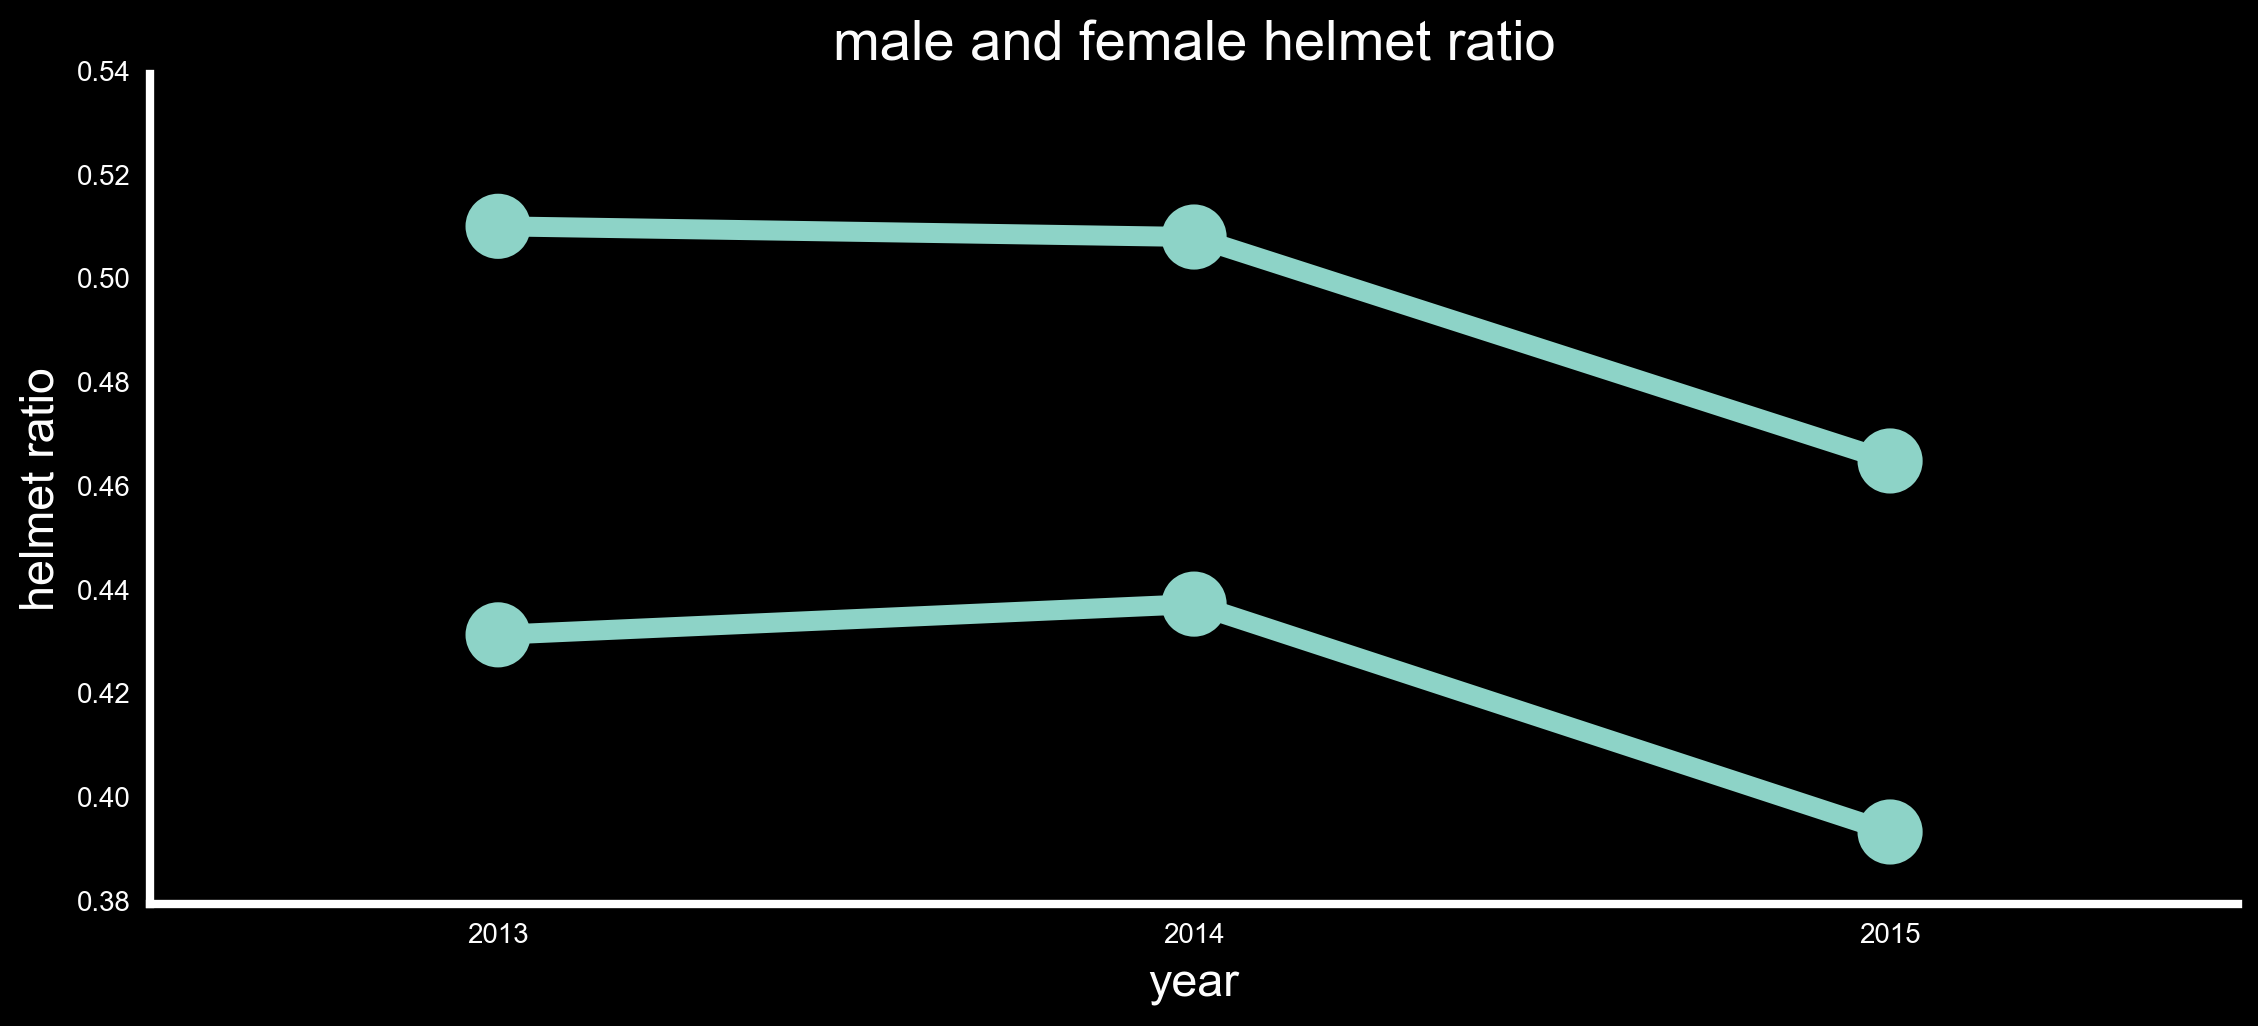

In [30]:
## plotting the ratio of the number of cyclists who wear helmets vs. total cyclists

plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
sns.pointplot(x='Year', y='m_helmet_ratio', data=m_helmet_groupby, ax=ax)
sns.pointplot(x='Year', y='f_helmet_ratio', data=f_helmet_groupby, ax=ax)
ax.set_title('male and female helmet ratio')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('year')
ax.set_ylabel('helmet ratio')
plt.plot();

### Now I want to look at the data by season and see if there's any seasonal trends

- Next I wanted to dig into my NYC collisions dataset and examine the different types of weather across the boroughs.
- Setting up different weather groupby's for each feature that I want to examine.

In [33]:
## Separating my data into separate seasons

NY_spring_13 = segment_func(NY_merged_samp, '03/20/2013', '06/21/2013')
NY_spring_14 = segment_func(NY_merged_samp, '03/20/2014', '06/21/2014')
NY_spring_15 = segment_func(NY_merged_samp, '03/20/2015', '06/21/2015')
NY_summer_13 = segment_func(NY_merged_samp, '06/22/2013', '09/22/2013')
NY_summer_14 = segment_func(NY_merged_samp, '06/22/2014', '09/22/2014')
NY_summer_15 = segment_func(NY_merged_samp, '06/22/2015', '09/22/2015')
NY_fall_13 = segment_func(NY_merged_samp, '09/23/2013', '12/21/2013')
NY_fall_14 = segment_func(NY_merged_samp, '09/23/2014', '12/21/2014')
NY_fall_15 = segment_func(NY_merged_samp, '09/23/2015', '12/21/2015')
NY_winter_13 = segment_func(NY_merged_samp, '01/01/2013', '03/19/2013')
NY_winter_14 = segment_func(NY_merged_samp, '12/22/2013', '03/19/2014')
NY_winter_15 = segment_func(NY_merged_samp, '12/22/2014', '03/19/2015')

NY_spring = NY_spring_13.append(NY_spring_14.append(NY_spring_15))
NY_summer = NY_summer_13.append(NY_summer_14.append(NY_summer_15))
NY_fall = NY_fall_13.append(NY_fall_14.append(NY_fall_15))
NY_winter = NY_winter_13.append(NY_winter_14.append(NY_winter_15))

NY_spring['month'] = month_extract(NY_spring['DATE'])
NY_summer['month'] = month_extract(NY_summer['DATE'])
NY_winter['month'] = month_extract(NY_winter['DATE'])
NY_fall['month'] = month_extract(NY_fall['DATE'])

In [34]:
## renaming the columns of the seasonal dataframes so can distinguish them when plotting

NY_spring.rename(columns={'injuries':'spring_injuries','precip':'spring_precip'}, inplace=True)
NY_summer.rename(columns={'injuries':'summer_injuries','precip':'summer_precip'}, inplace=True)
NY_winter.rename(columns={'injuries':'winter_injuries','precip':'winter_precip'}, inplace=True)
NY_fall.rename(columns={'injuries':'fall_injuries','precip':'fall_precip'}, inplace=True)

In [35]:
spring_13 = NY_spring_13.groupby(['month'],as_index=False)['injuries'].sum()
spring_14 = NY_spring_14.groupby(['month'],as_index=False)['injuries'].sum()
spring_15 = NY_spring_15.groupby(['month'],as_index=False)['injuries'].sum()

summer_13 = NY_summer_13.groupby(['month'],as_index=False)['injuries'].sum()
summer_14 = NY_summer_14.groupby(['month'],as_index=False)['injuries'].sum()
summer_15 = NY_summer_15.groupby(['month'],as_index=False)['injuries'].sum()

winter_13 = NY_winter_13.groupby(['month'],as_index=False)['injuries'].sum()
winter_14 = NY_winter_14.groupby(['month'],as_index=False)['injuries'].sum()
winter_15 = NY_winter_15.groupby(['month'],as_index=False)['injuries'].sum()

fall_13 = NY_fall_13.groupby(['month'],as_index=False)['injuries'].sum()
fall_14 = NY_fall_14.groupby(['month'],as_index=False)['injuries'].sum()
fall_15 = NY_fall_15.groupby(['month'],as_index=False)['injuries'].sum()

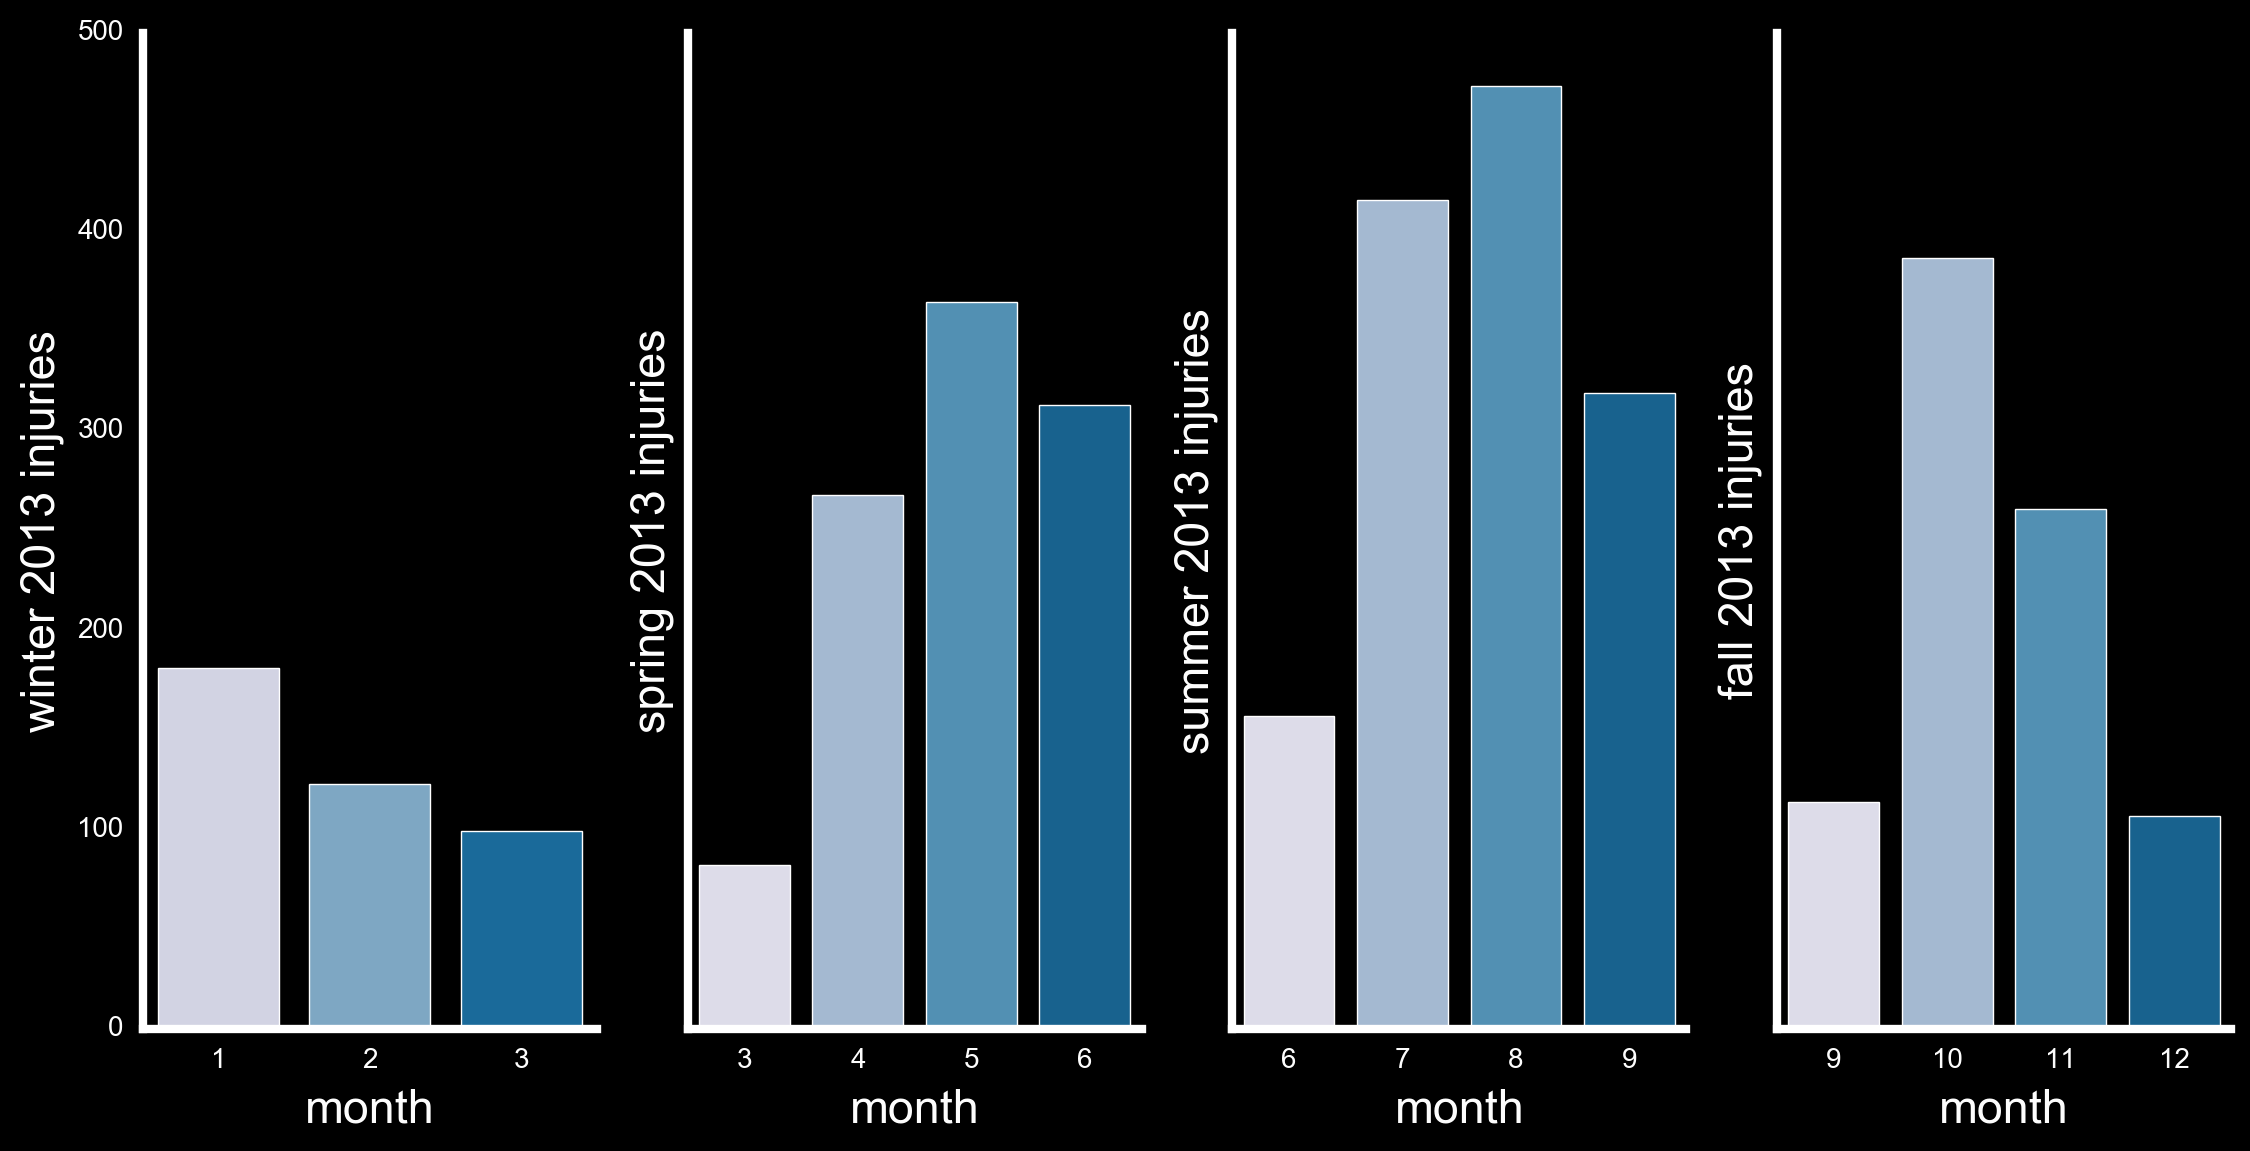

In [36]:
plt.style.use('dark_background')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(12,6))
sns.barplot(x='month', y='injuries', data=winter_13, ax=ax1,hue=None, palette='PuBu')
sns.barplot(x='month', y='injuries', data=spring_13, ax=ax2,hue=None,palette='PuBu')
sns.barplot(x='month', y='injuries', data=summer_13, ax=ax3,hue=None,palette='PuBu')
sns.barplot(x='month', y='injuries', data=fall_13, ax=ax4,hue=None, palette='PuBu')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax1.set_ylabel('winter 2013 injuries')
ax2.set_ylabel('spring 2013 injuries')
ax3.set_ylabel('summer 2013 injuries')
ax4.set_ylabel('fall 2013 injuries')
plt.plot();

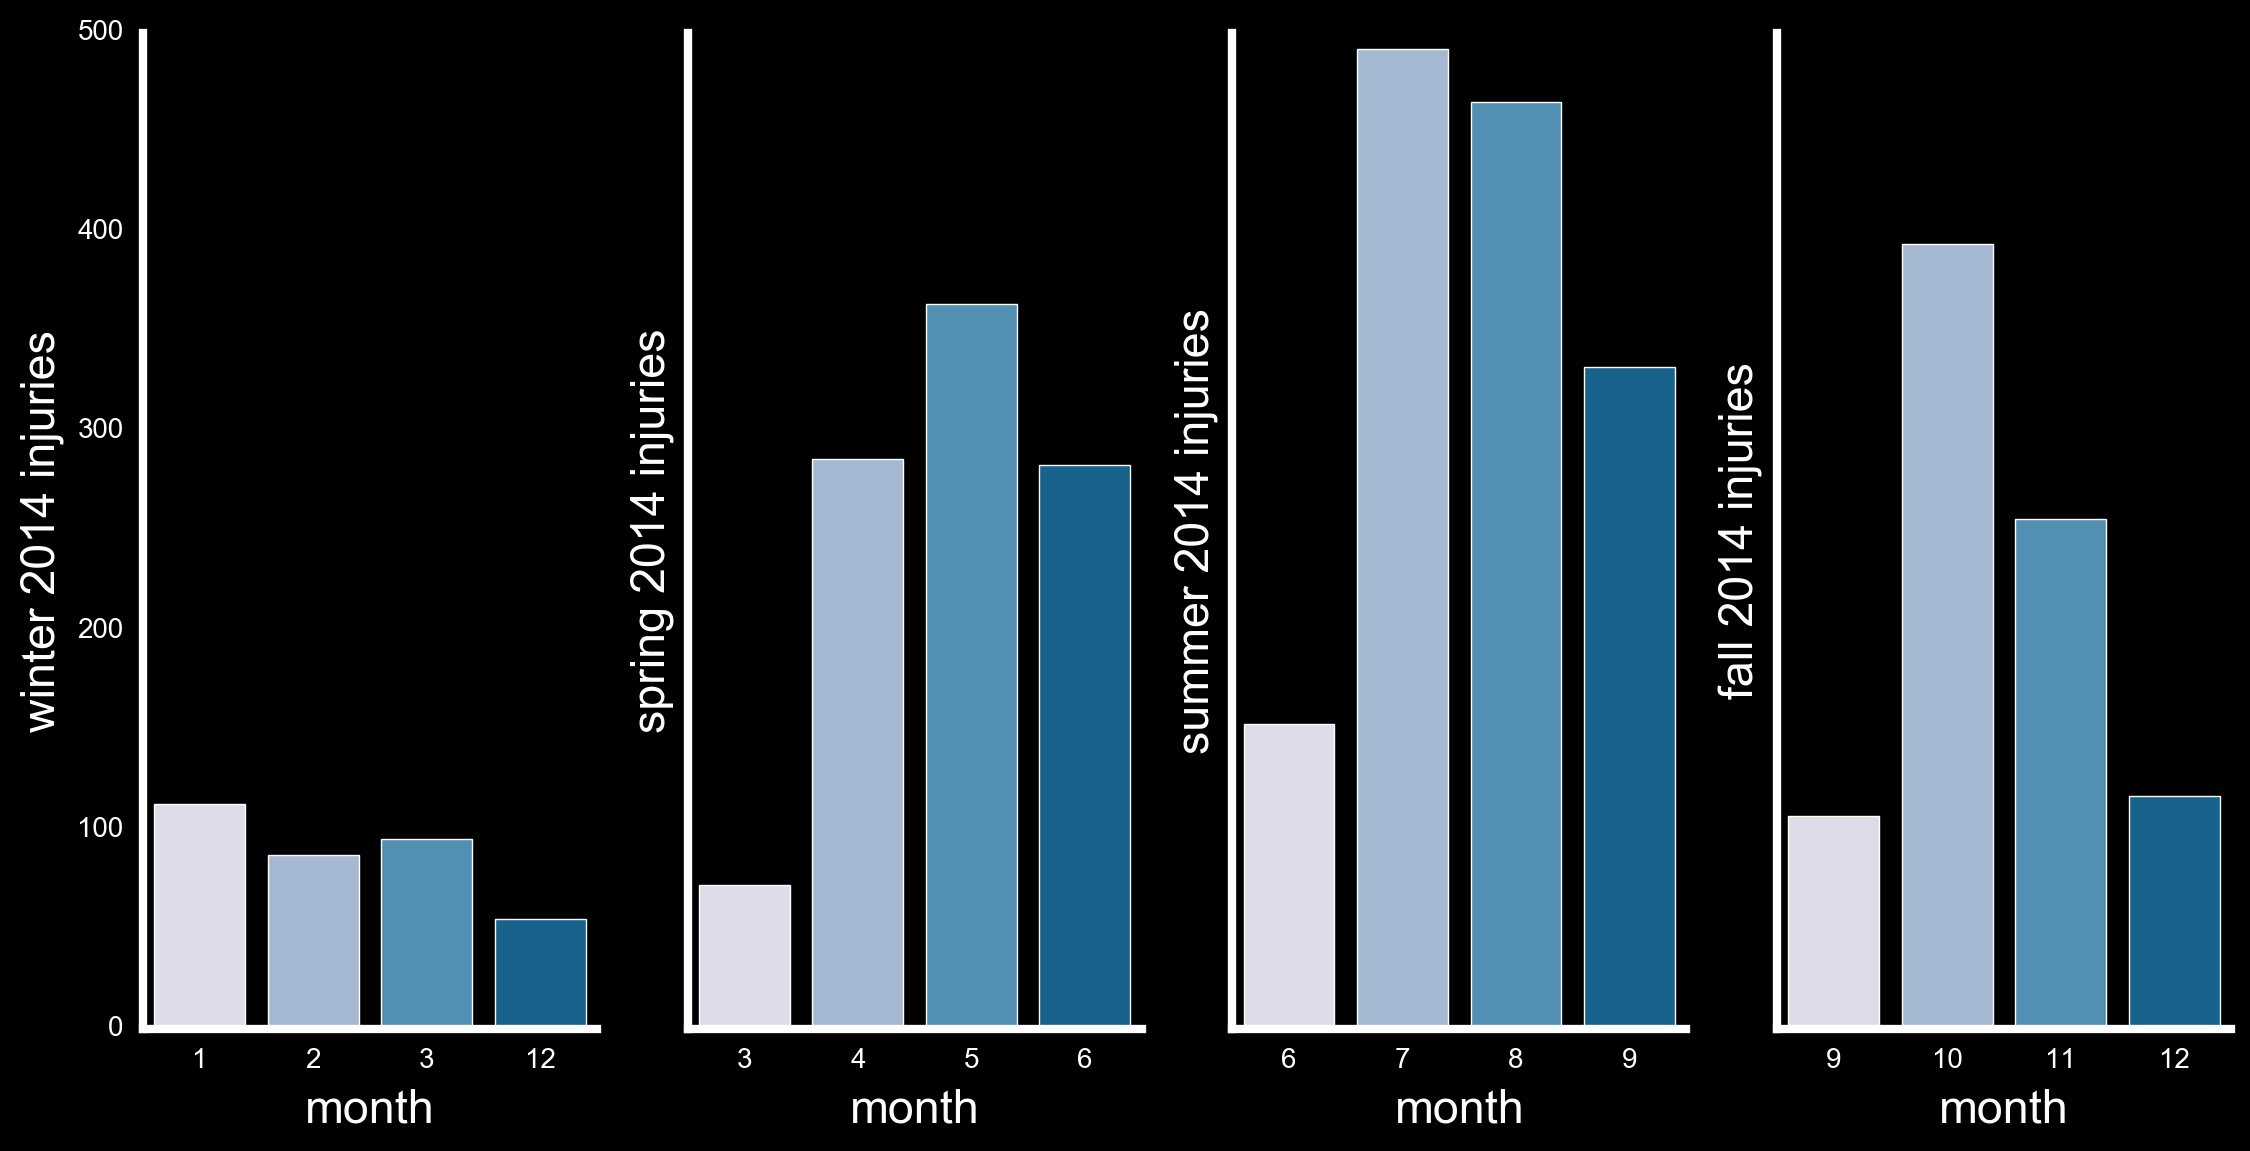

In [37]:
plt.style.use('dark_background')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(12,6))
sns.barplot(x='month', y='injuries', data=winter_14, ax=ax1,hue=None,palette='PuBu')
sns.barplot(x='month', y='injuries', data=spring_14, ax=ax2,hue=None,palette='PuBu')
sns.barplot(x='month', y='injuries', data=summer_14, ax=ax3,hue=None,palette='PuBu')
sns.barplot(x='month', y='injuries', data=fall_14, ax=ax4,hue=None,palette='PuBu')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax1.set_ylabel('winter 2014 injuries')
ax2.set_ylabel('spring 2014 injuries')
ax3.set_ylabel('summer 2014 injuries')
ax4.set_ylabel('fall 2014 injuries')
plt.plot();

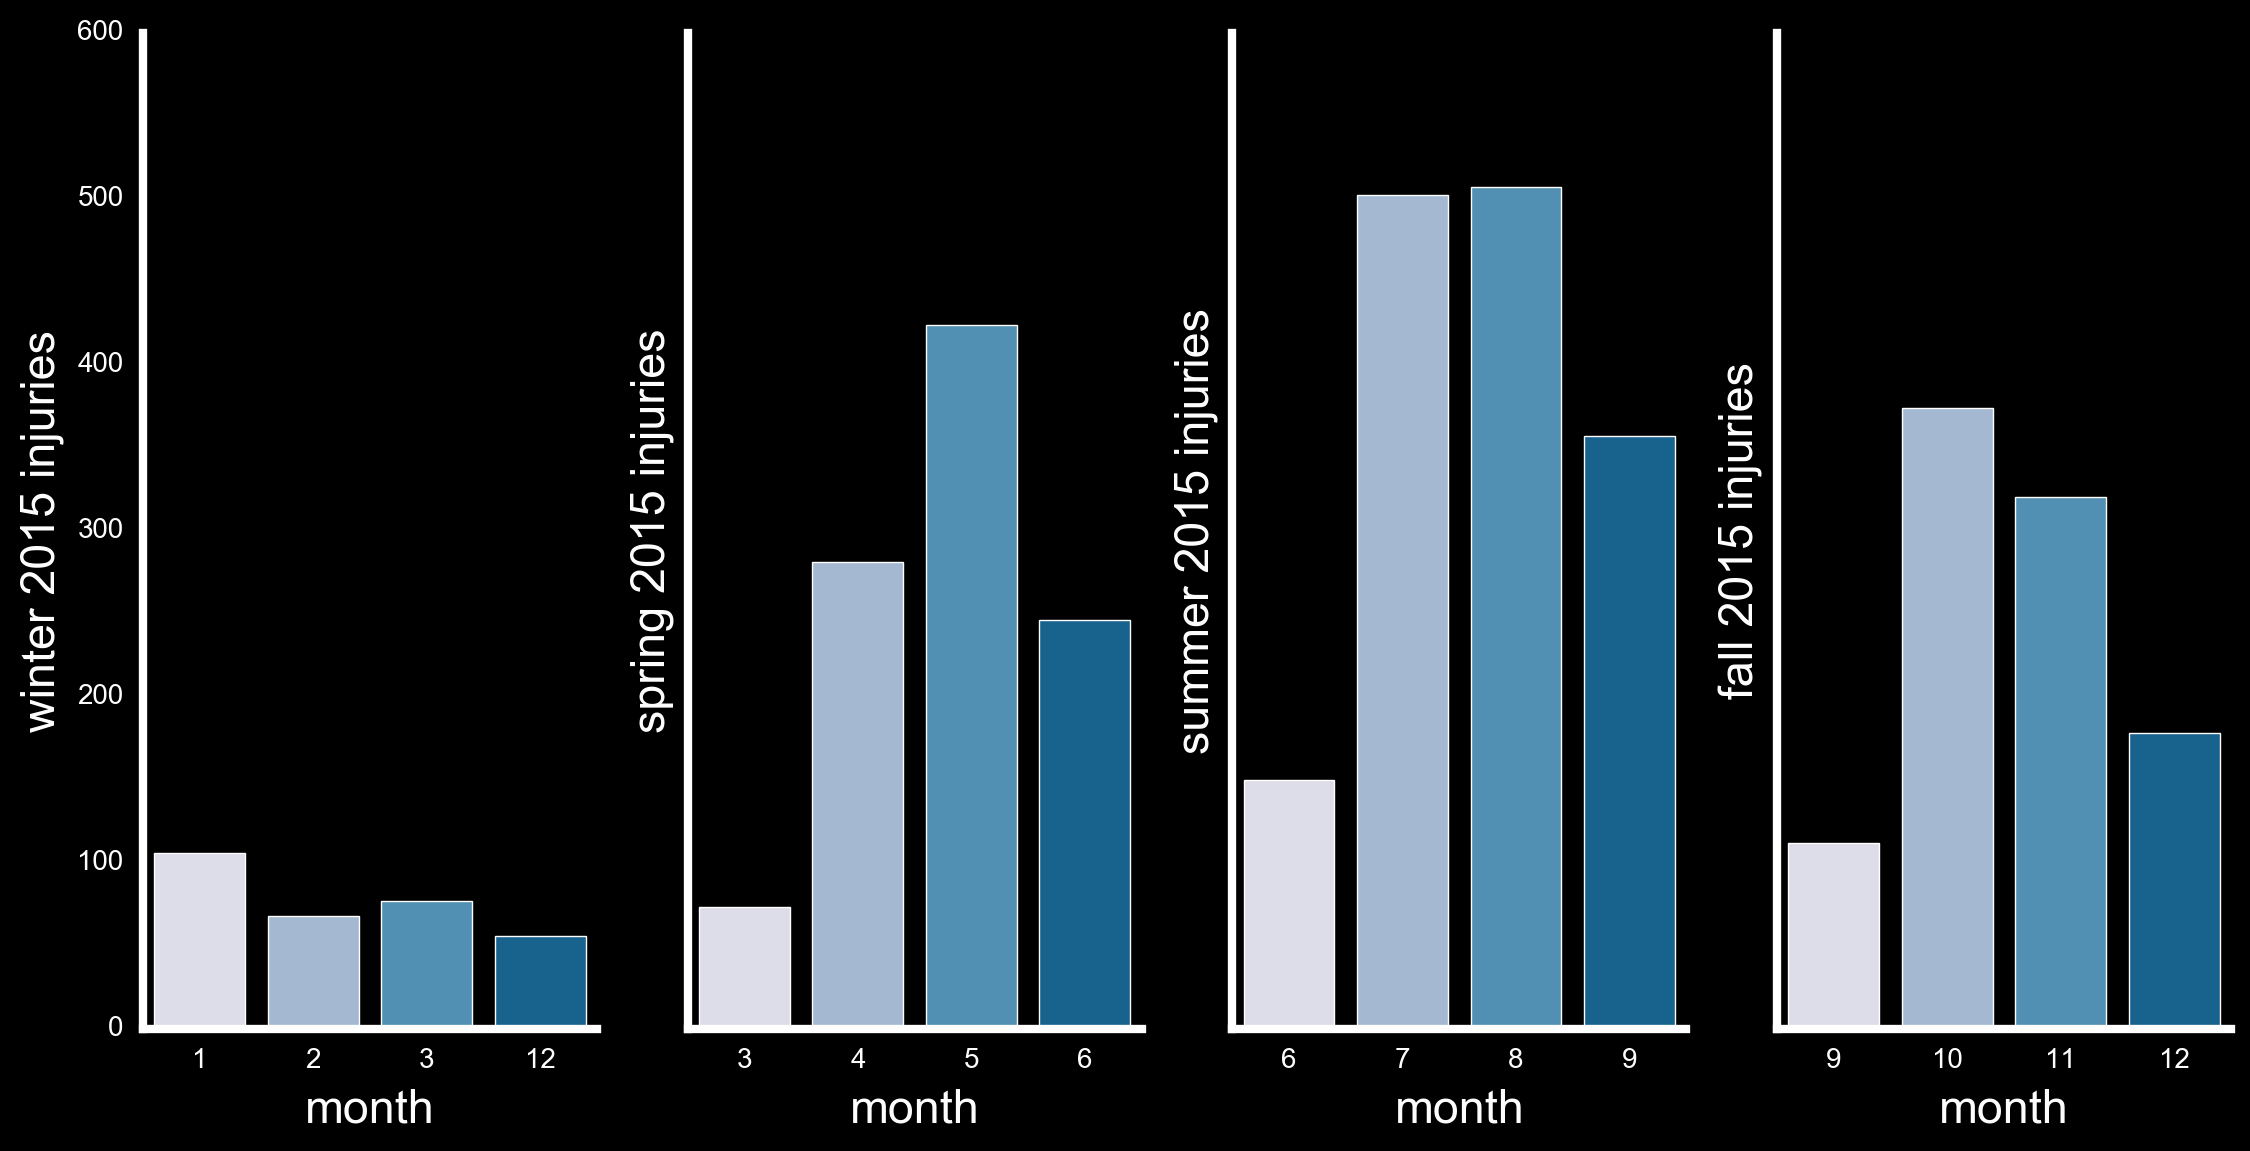

In [38]:
plt.style.use('dark_background')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(12,6))
sns.barplot(x='month', y='injuries', data=winter_15, ax=ax1,hue=None, palette='PuBu')
sns.barplot(x='month', y='injuries', data=spring_15, ax=ax2,hue=None, palette='PuBu')
sns.barplot(x='month', y='injuries', data=summer_15, ax=ax3,hue=None, palette='PuBu')
sns.barplot(x='month', y='injuries', data=fall_15, ax=ax4,hue=None, palette='PuBu')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax1.set_ylabel('winter 2015 injuries')
ax2.set_ylabel('spring 2015 injuries')
ax3.set_ylabel('summer 2015 injuries')
ax4.set_ylabel('fall 2015 injuries')
plt.plot();

In [40]:
NY_mask = NY_merged_samp[NY_merged_samp['BOROUGH'] != 0]
NY_mask = NY_mask[NY_mask['injuries'] > 0]
NY_mask.head()

,DATE,TIME,BOROUGH,ZIP_CODE,LATITUDE,LONGITUDE,LOCATION,ON_STREET_NAME,CROSS_STREET_NAME,OFF_STREET_NAME,...,borough_cat,precip_scale,month,injuries_binary,temp_cat,dew_cat,humid_cat,day_of_week,year,month_name
100637,2013-01-01,16.0,BROOKLYN,11207.0,40.690029,-73.910995,"(40.6900286, -73.9109952)",HALSEY STREET,CENTRAL AVENUE,0,...,1,0,1,1,3,3,4,1,2013,Jan
100638,2013-01-01,16.0,BROOKLYN,11217.0,40.679046,-73.978678,"(40.6790463, -73.9786781)",5 AVENUE,STERLING PLACE,0,...,1,0,1,1,3,3,4,1,2013,Jan
100788,2013-01-01,3.0,BROOKLYN,11204.0,40.612692,-73.982658,"(40.6126918, -73.9826576)",BAY PARKWAY,67 STREET,0,...,1,0,1,1,3,3,4,1,2013,Jan
101245,2013-01-02,15.0,BROOKLYN,11249.0,40.701656,-73.960609,"(40.7016557, -73.9606094)",WILLIAMSBURG STREET EAST,HEWES STREET,0,...,1,0,1,1,3,2,4,2,2013,Jan
101305,2013-01-02,21.0,MANHATTAN,10016.0,40.748986,-73.979955,"(40.7489858, -73.979955)",EAST 37 STREET,PARK AVENUE,0,...,2,0,1,1,3,2,4,2,2013,Jan


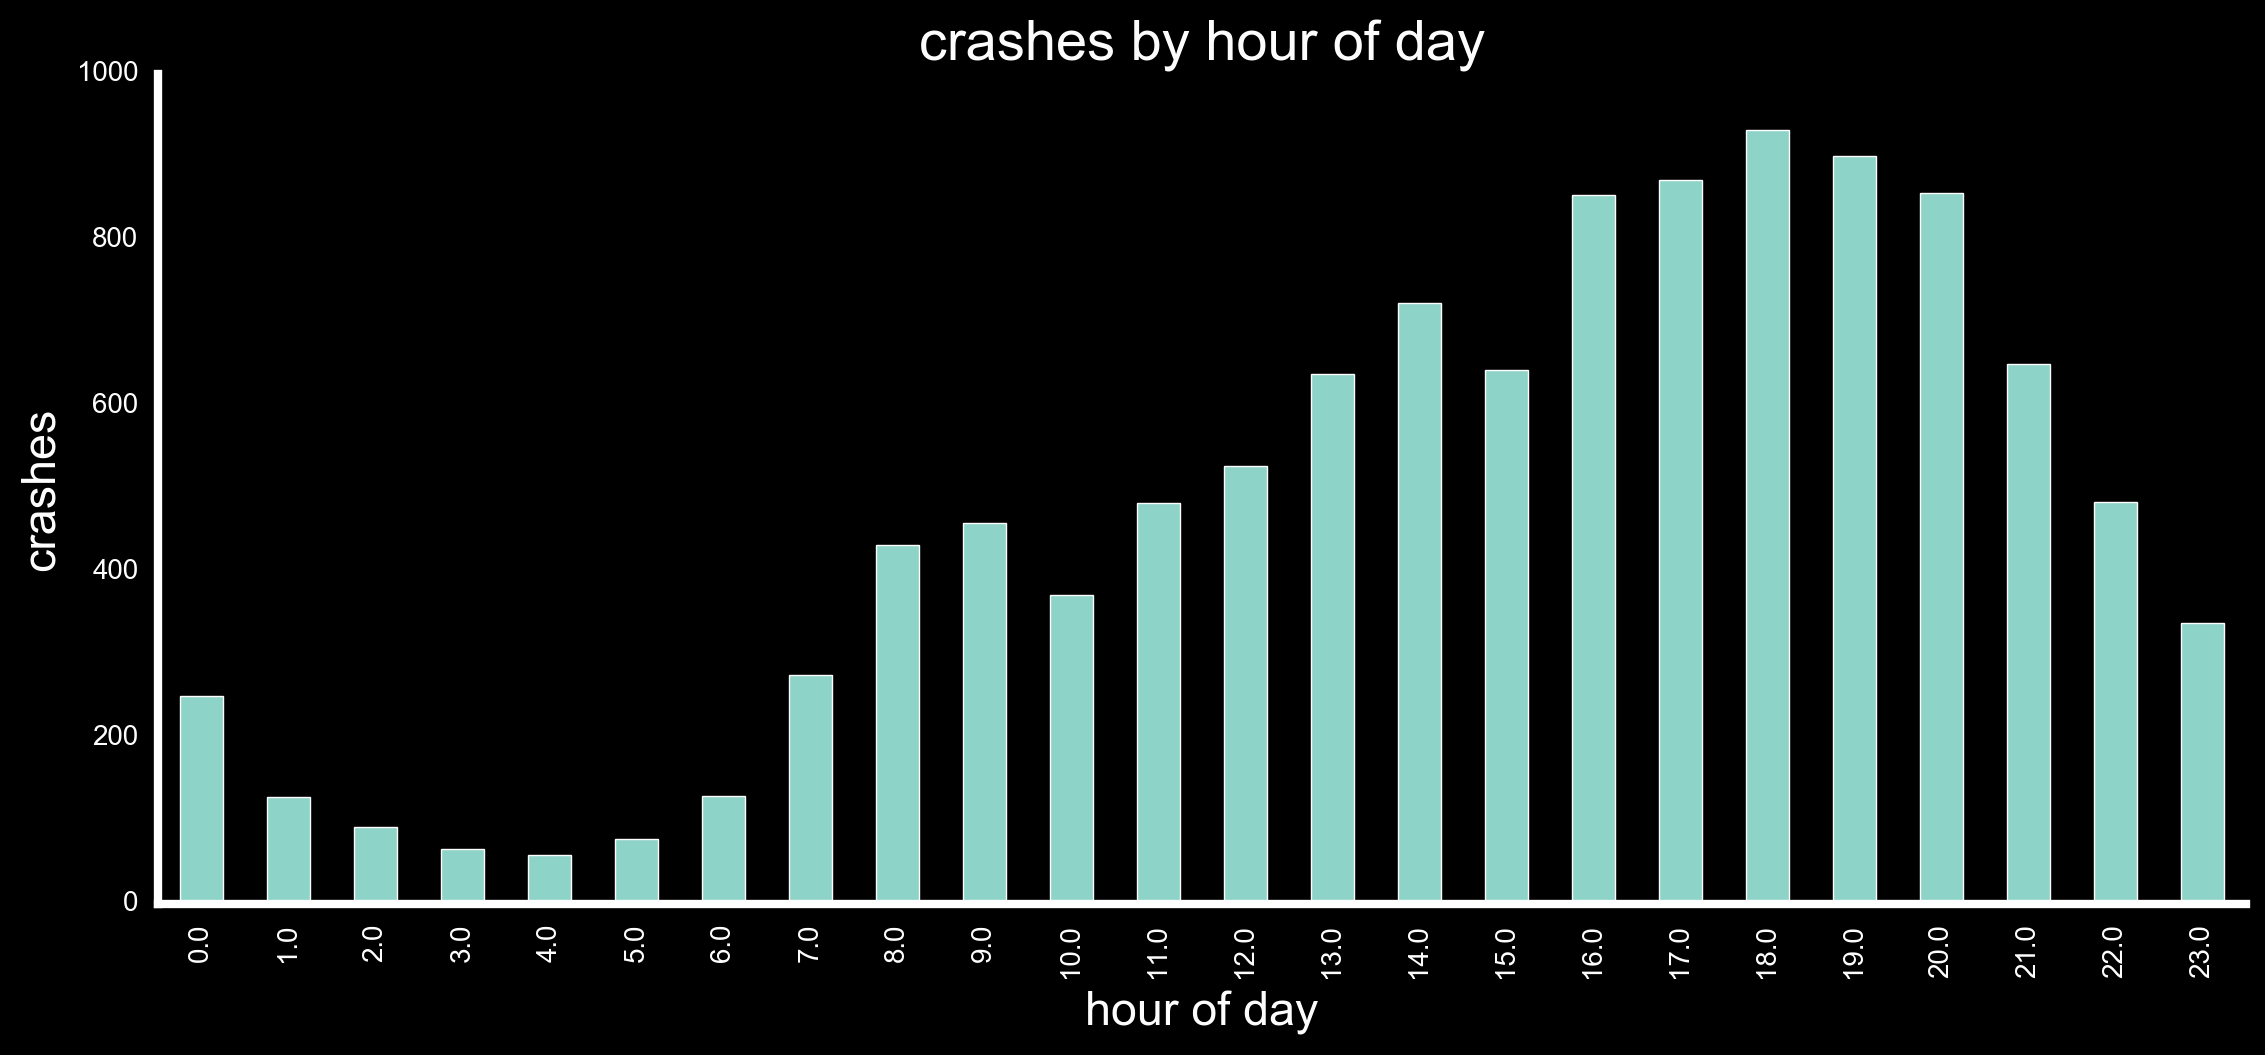

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
NY_mask.groupby(['TIME'])['injuries'].sum().plot(kind='bar')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('crashes')
ax.set_title('crashes by hour of day')
ax.set_xlabel('hour of day')
plt.plot();

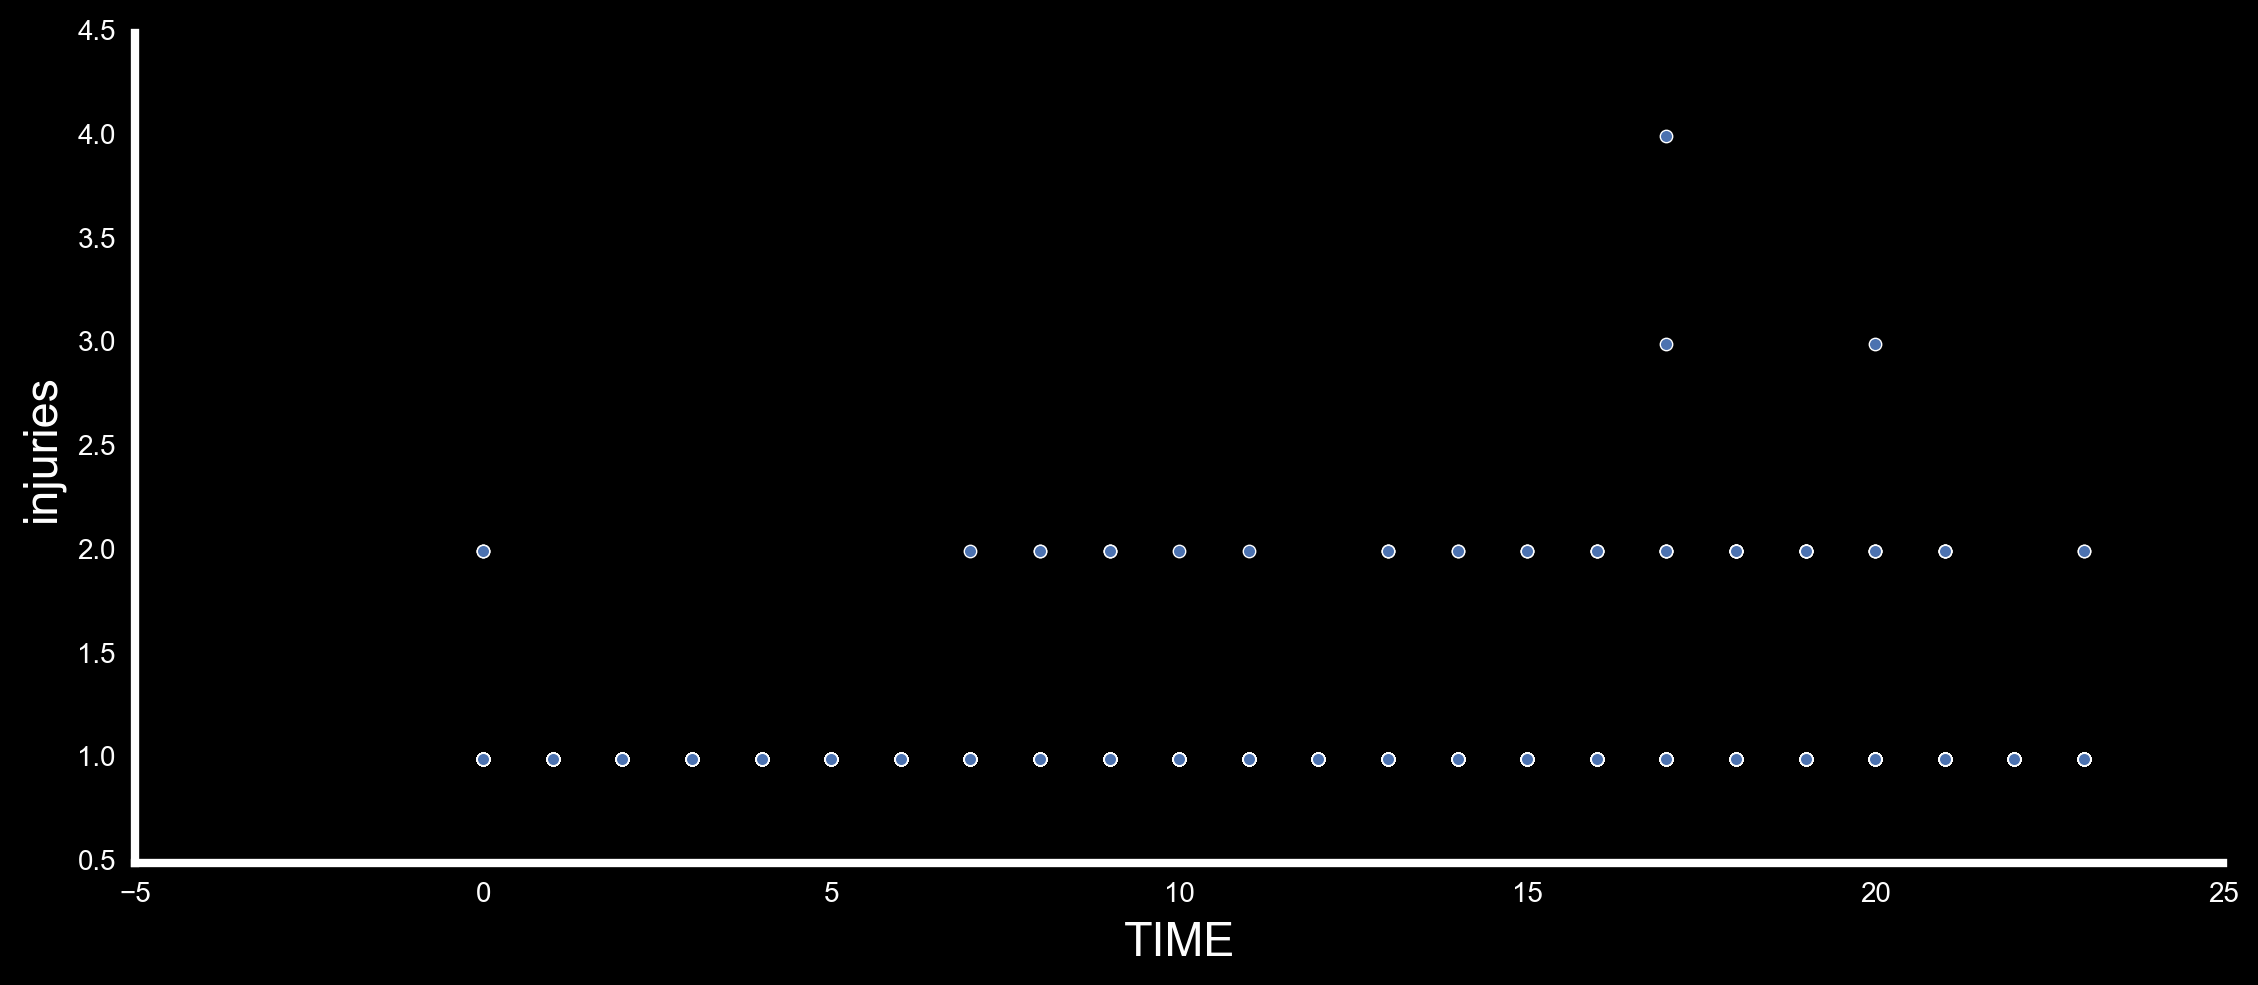

In [47]:
fig, ax = plt.subplots(figsize=(12,5))
NY_mask.plot(kind='scatter', x='TIME', y='injuries', ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot();

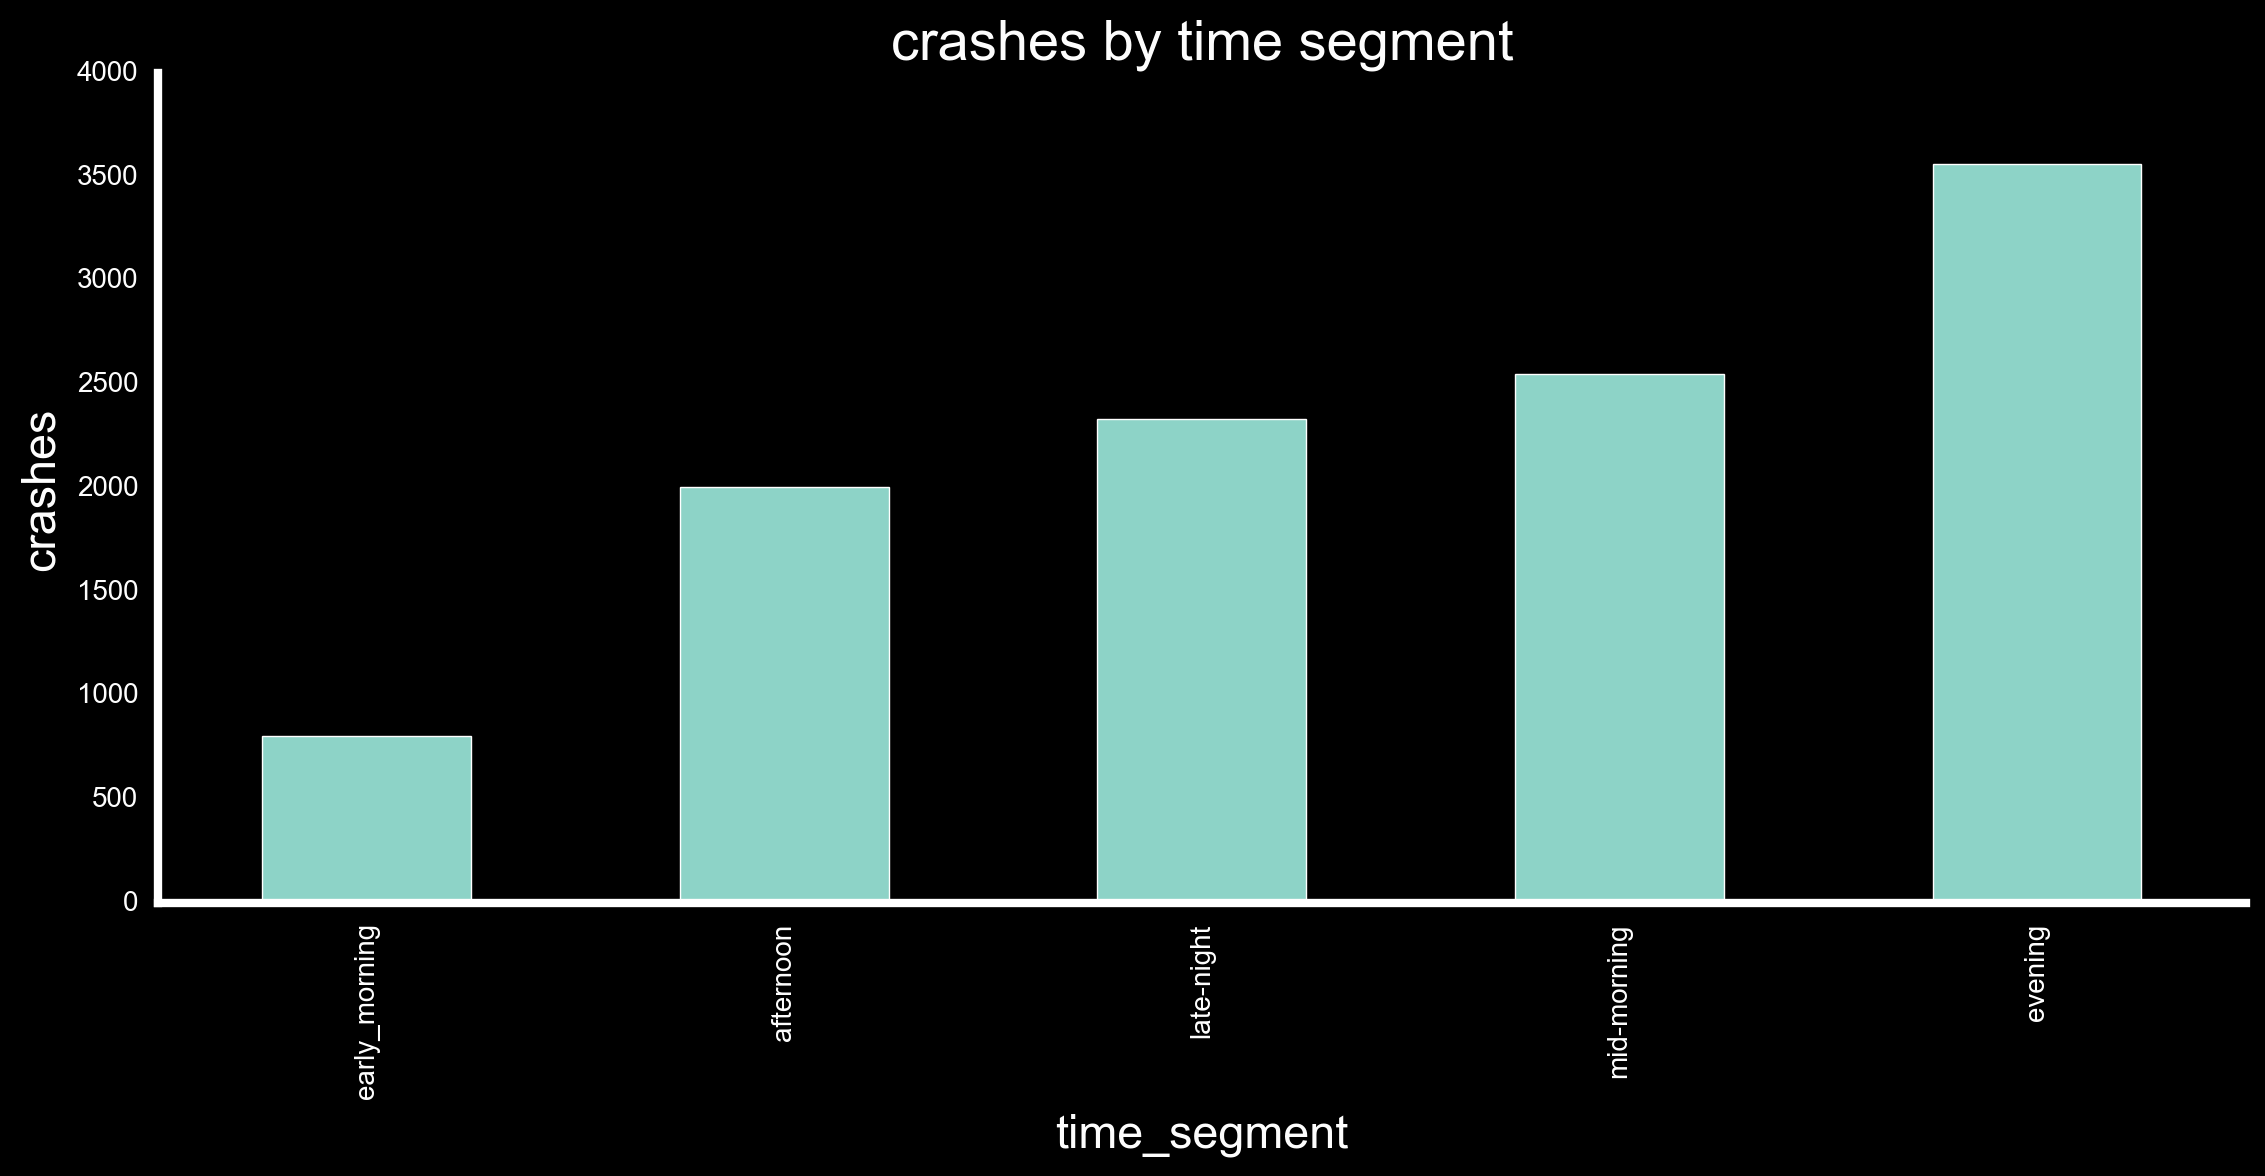

In [43]:
fig, ax = plt.subplots(figsize=(12,5))
NY_merged_samp.groupby(['time_segment'])['injuries'].sum().sort_values().plot(kind='bar')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('crashes')
ax.set_title('crashes by time segment')
plt.plot();

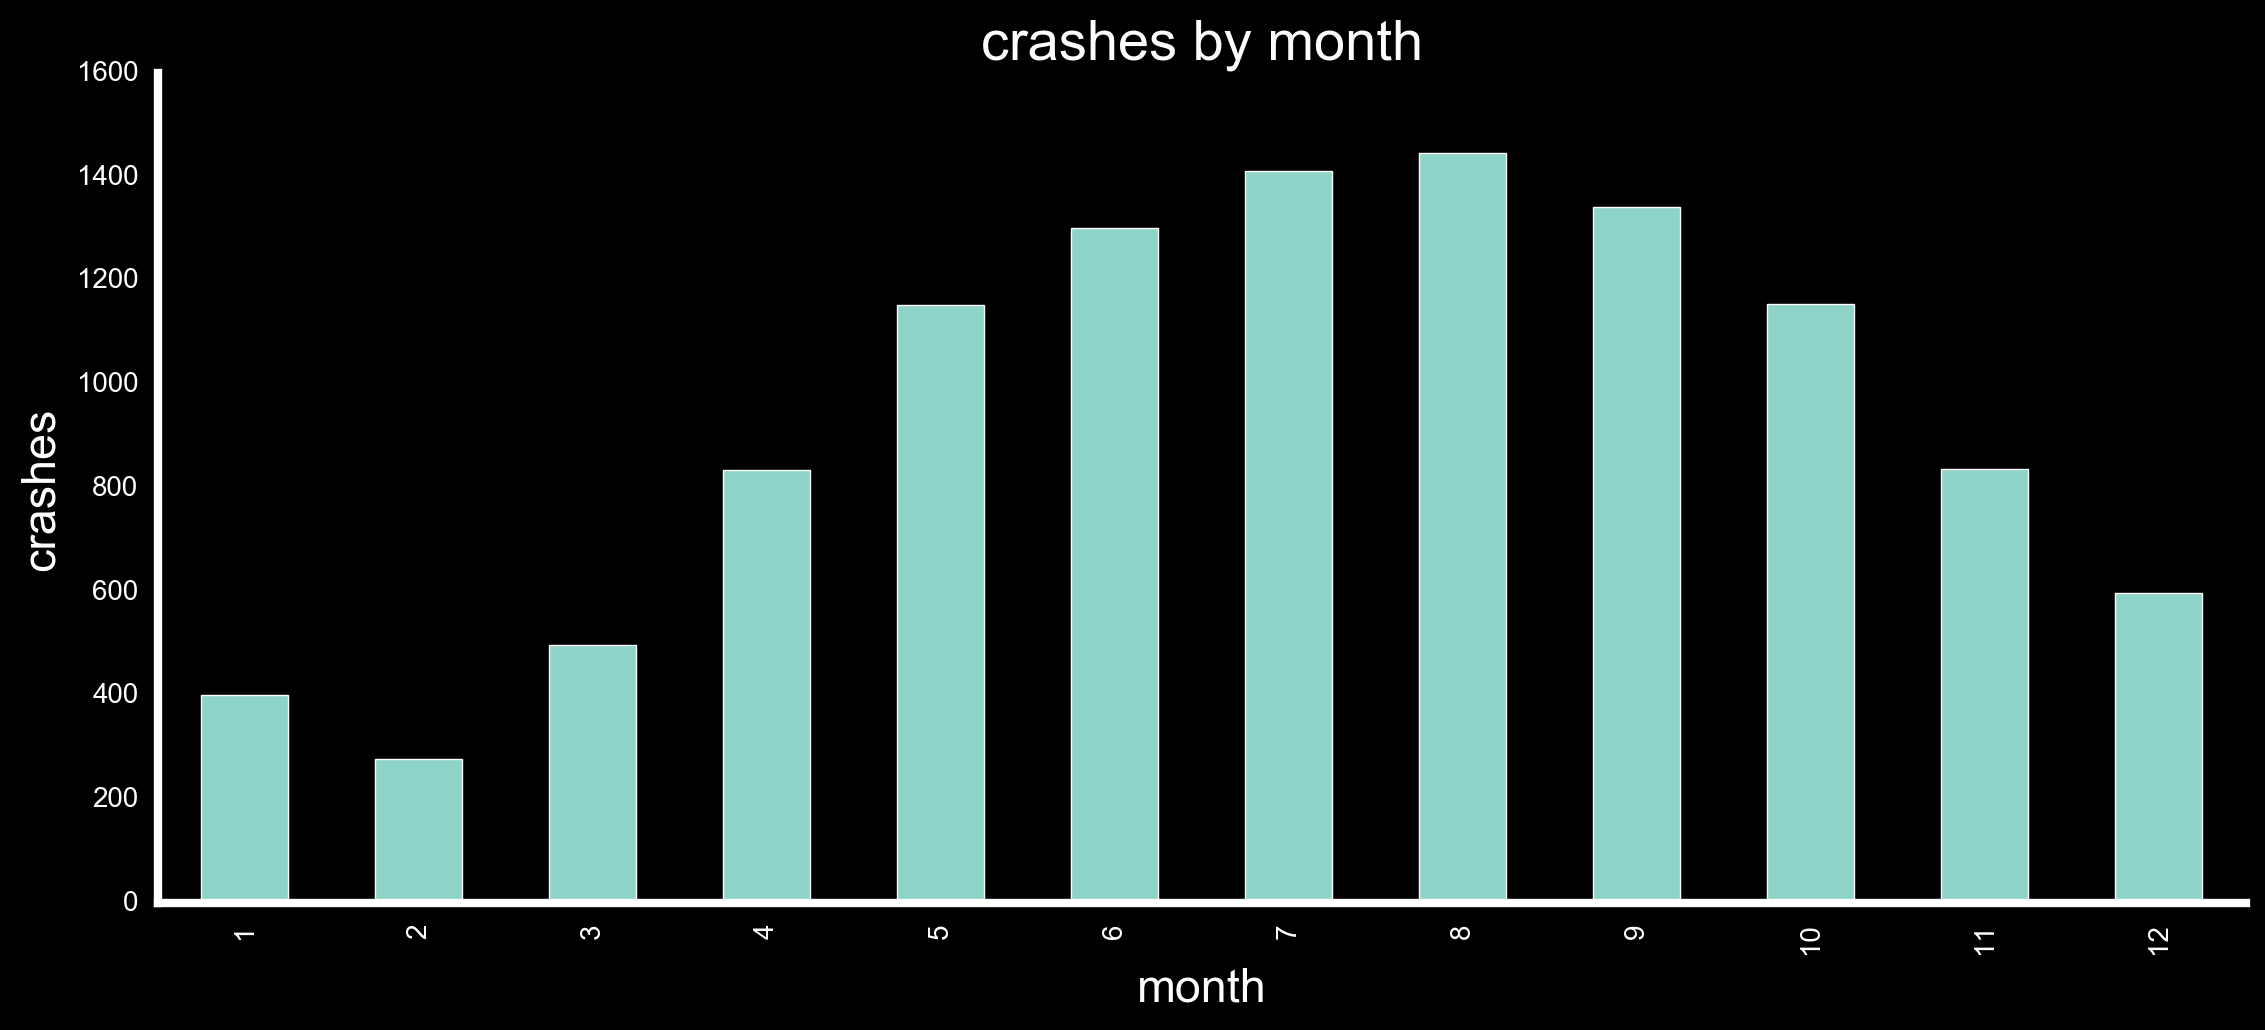

In [44]:
fig, ax = plt.subplots(figsize=(12,5))
NY_merged_samp.groupby(['month'])['injuries'].sum().plot(kind='bar')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('crashes')
ax.set_title('crashes by month')
plt.plot();

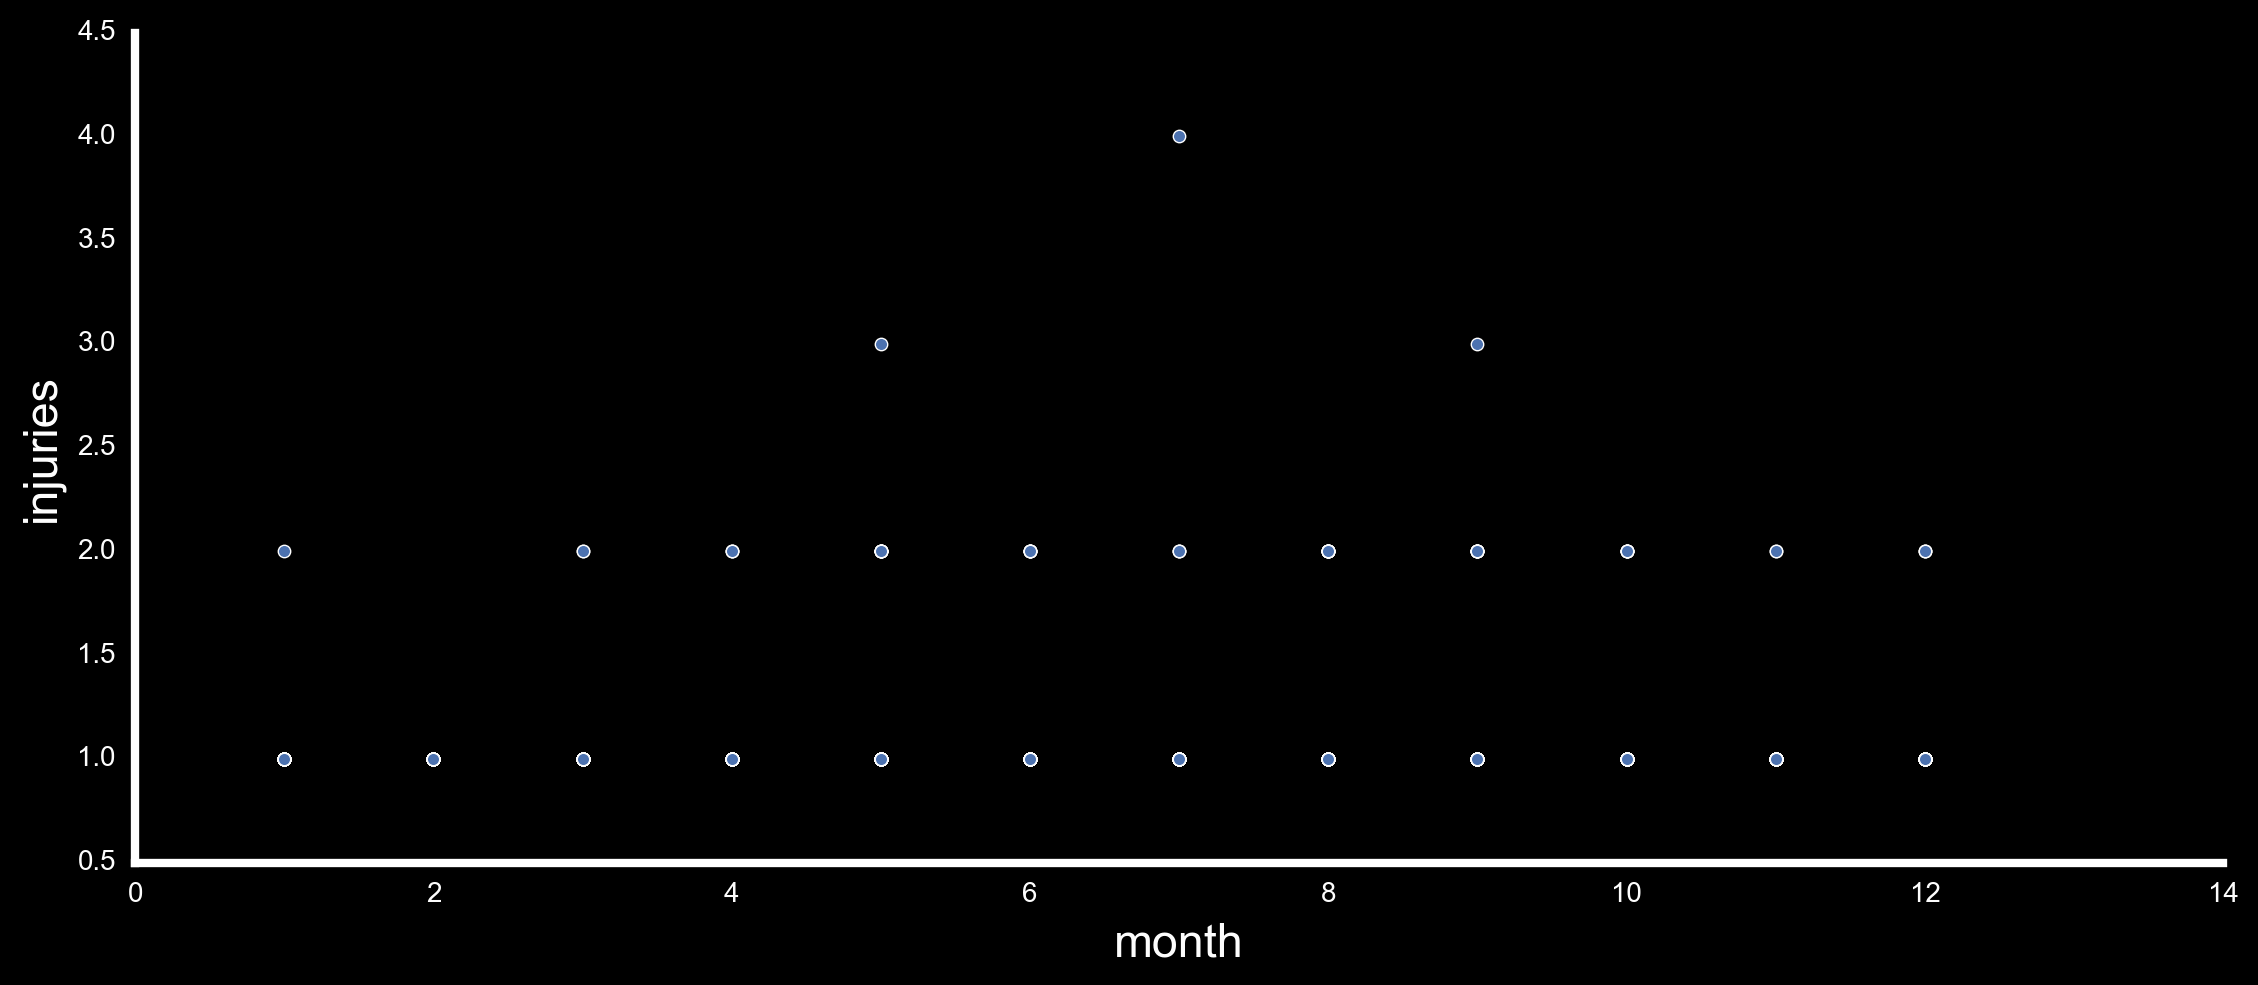

In [48]:
fig, ax = plt.subplots(figsize=(12,5))
NY_mask.plot(kind='scatter', x='month', y='injuries', ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot();

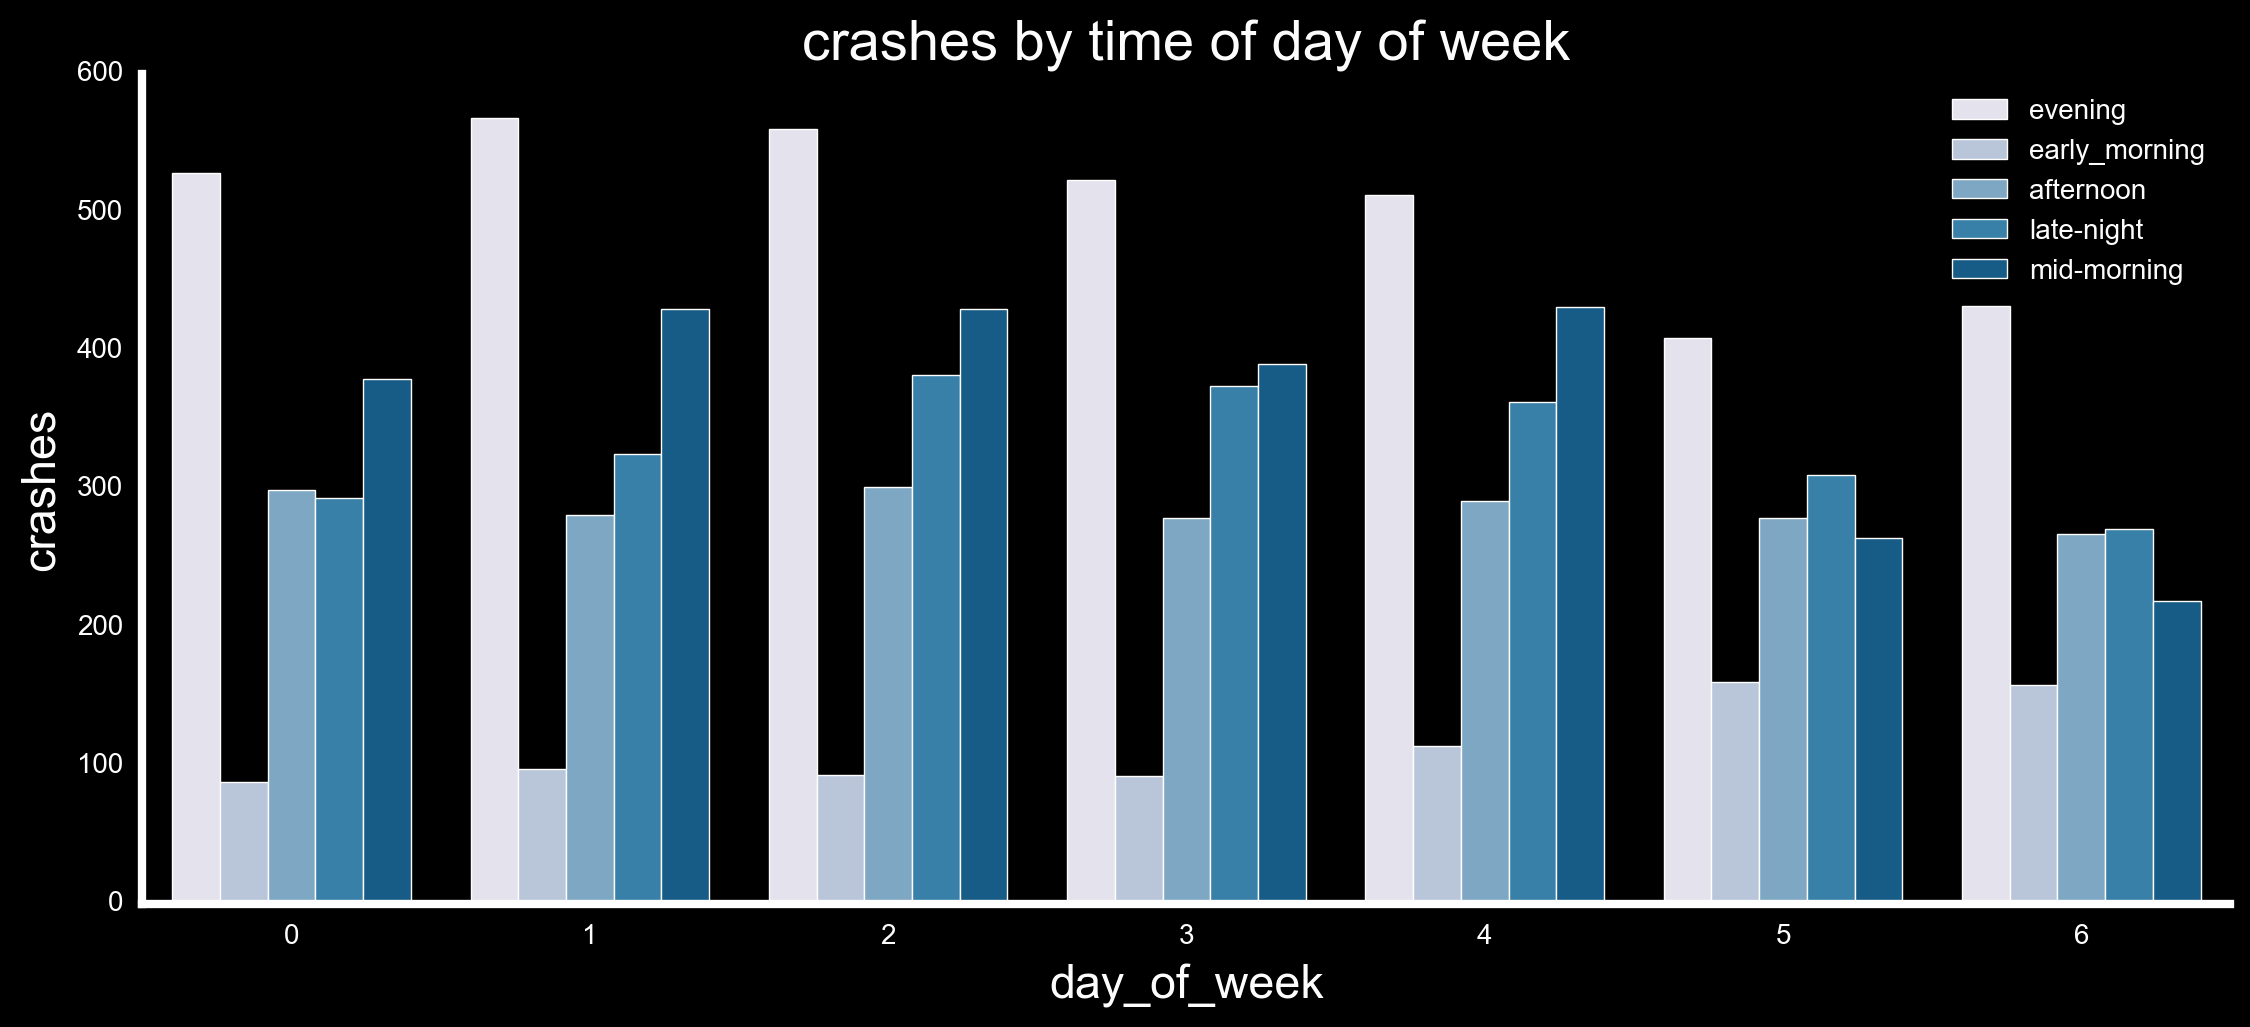

In [49]:
fig, ax = plt.subplots(figsize=(12,5))
# NY_merged_samp.groupby(['day_of_week'])['injuries'].sum().plot(kind='bar')
sns.countplot(x='day_of_week', data=NY_mask, hue='time_segment', palette='PuBu')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('crashes')
ax.legend(loc='upper right')
ax.set_title('crashes by time of day of week')
plt.plot();

In [50]:
NY_vehicle_group = NY_mask.groupby(['BOROUGH','VEHICLE_TYPE_CODE_1'], as_index=False)['injuries'].sum()
NY_vehicle_group = NY_vehicle_group.sort_values(by='injuries', ascending=False).head(20)
NY_vehicle_group

,BOROUGH,VEHICLE_TYPE_CODE_1,injuries
23,BROOKLYN,PASSENGER VEHICLE,2344
56,QUEENS,PASSENGER VEHICLE,1214
40,MANHATTAN,PASSENGER VEHICLE,1193
27,BROOKLYN,SPORT UTILITY / STATION WAGON,1057
46,MANHATTAN,TAXI,896
60,QUEENS,SPORT UTILITY / STATION WAGON,518
45,MANHATTAN,SPORT UTILITY / STATION WAGON,513
7,BRONX,PASSENGER VEHICLE,496
29,BROOKLYN,UNKNOWN,372
47,MANHATTAN,UNKNOWN,206


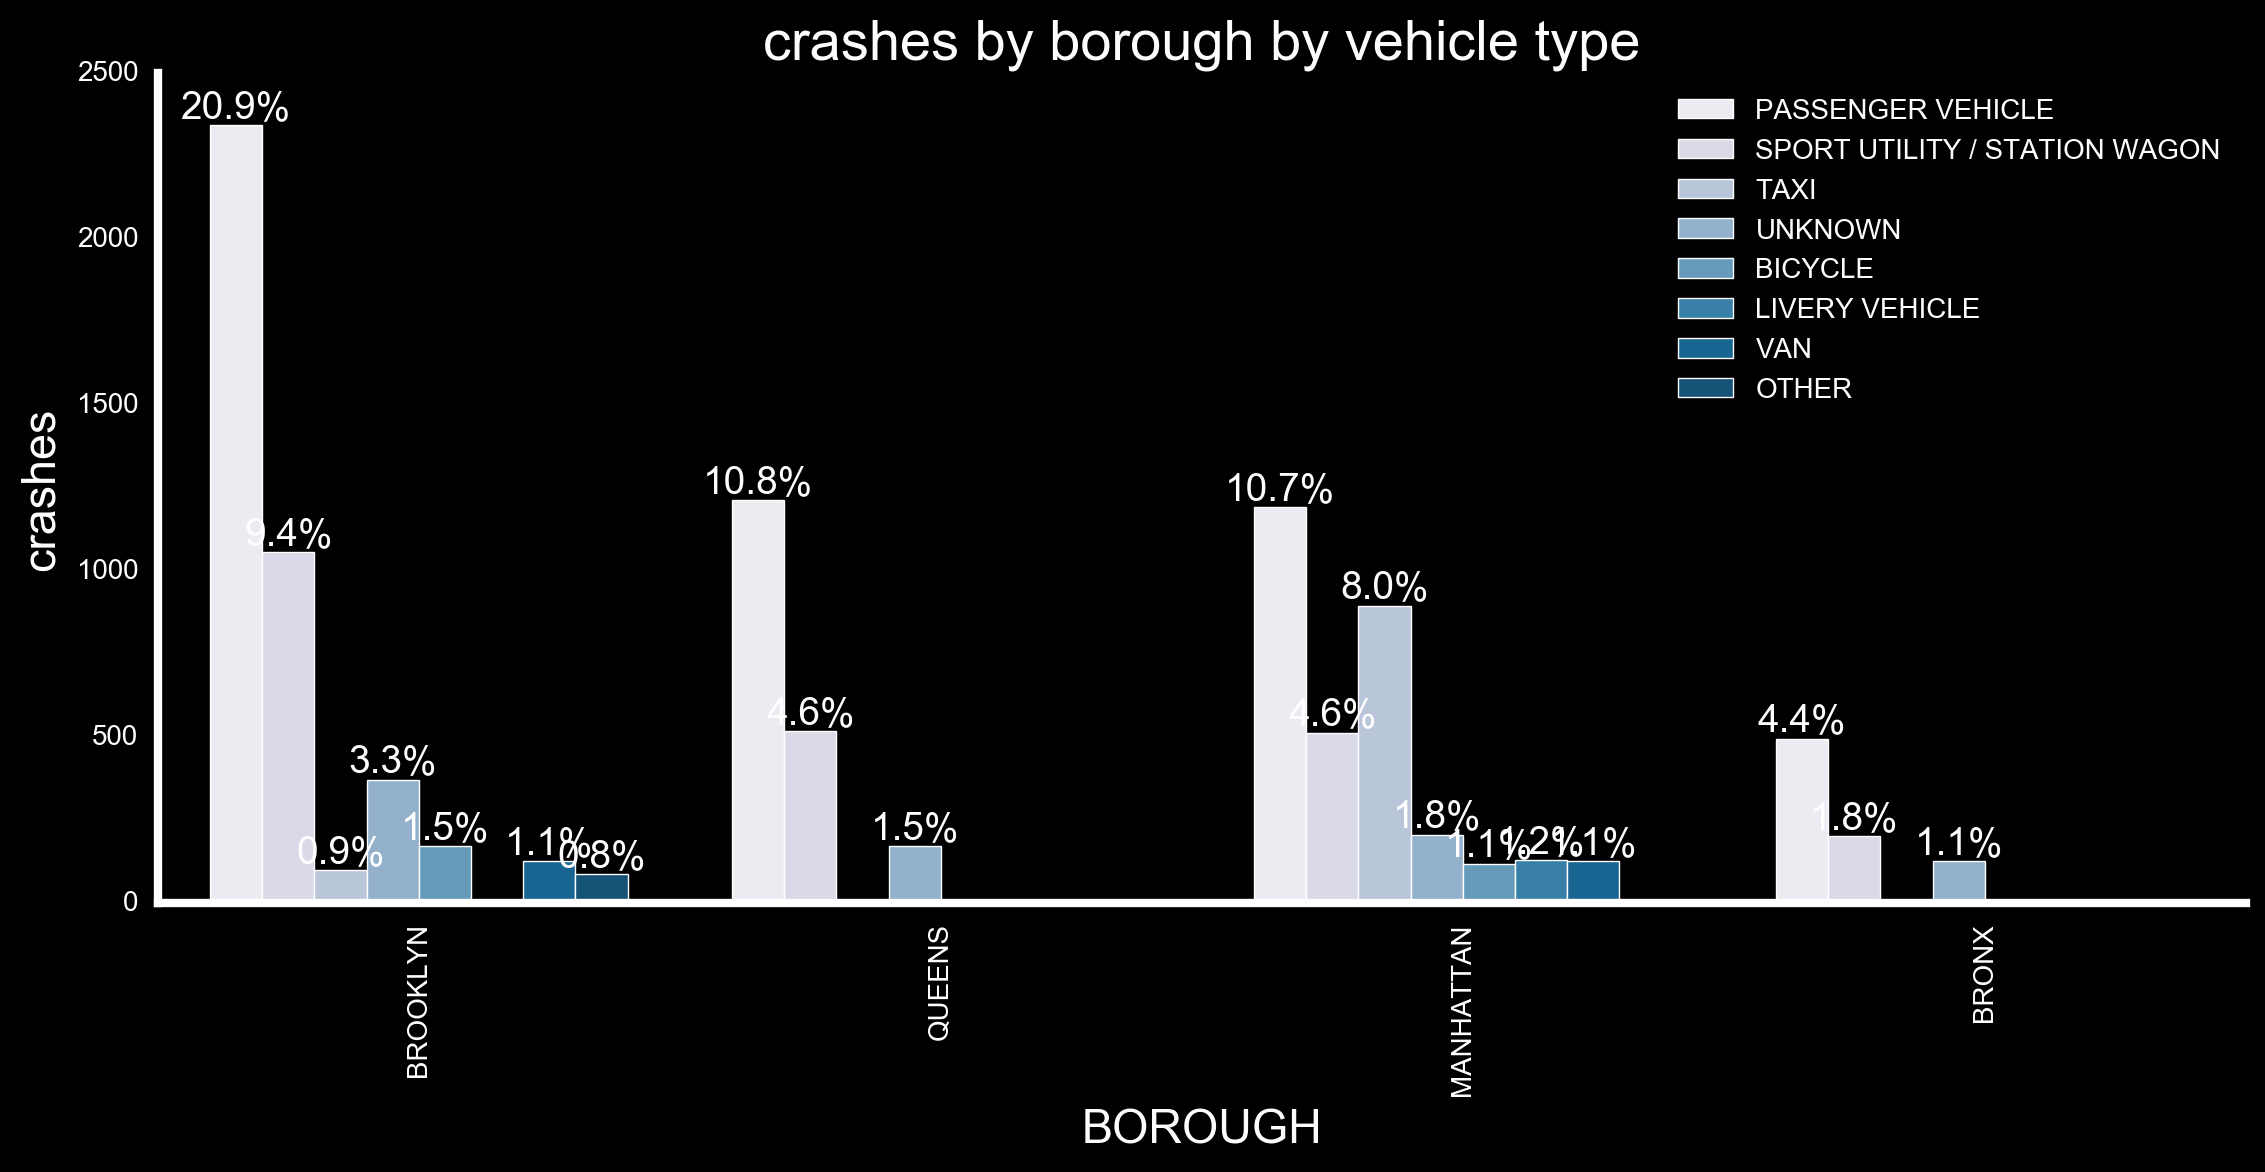

In [51]:
ncount = len(NY_mask)
fig, ax = plt.subplots(figsize=(12,5))
# NY_merged_samp.groupby(['day_of_week'])['injuries'].sum().plot(kind='bar')
vehicle_plot = sns.barplot(x='BOROUGH', y='injuries', data=NY_vehicle_group, hue='VEHICLE_TYPE_CODE_1', palette='PuBu')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('crashes')
ax.set_title('crashes by borough by vehicle type')
ax.legend(loc='upper right')
for item in vehicle_plot.get_xticklabels():
    item.set_rotation(90)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom')
plt.plot();

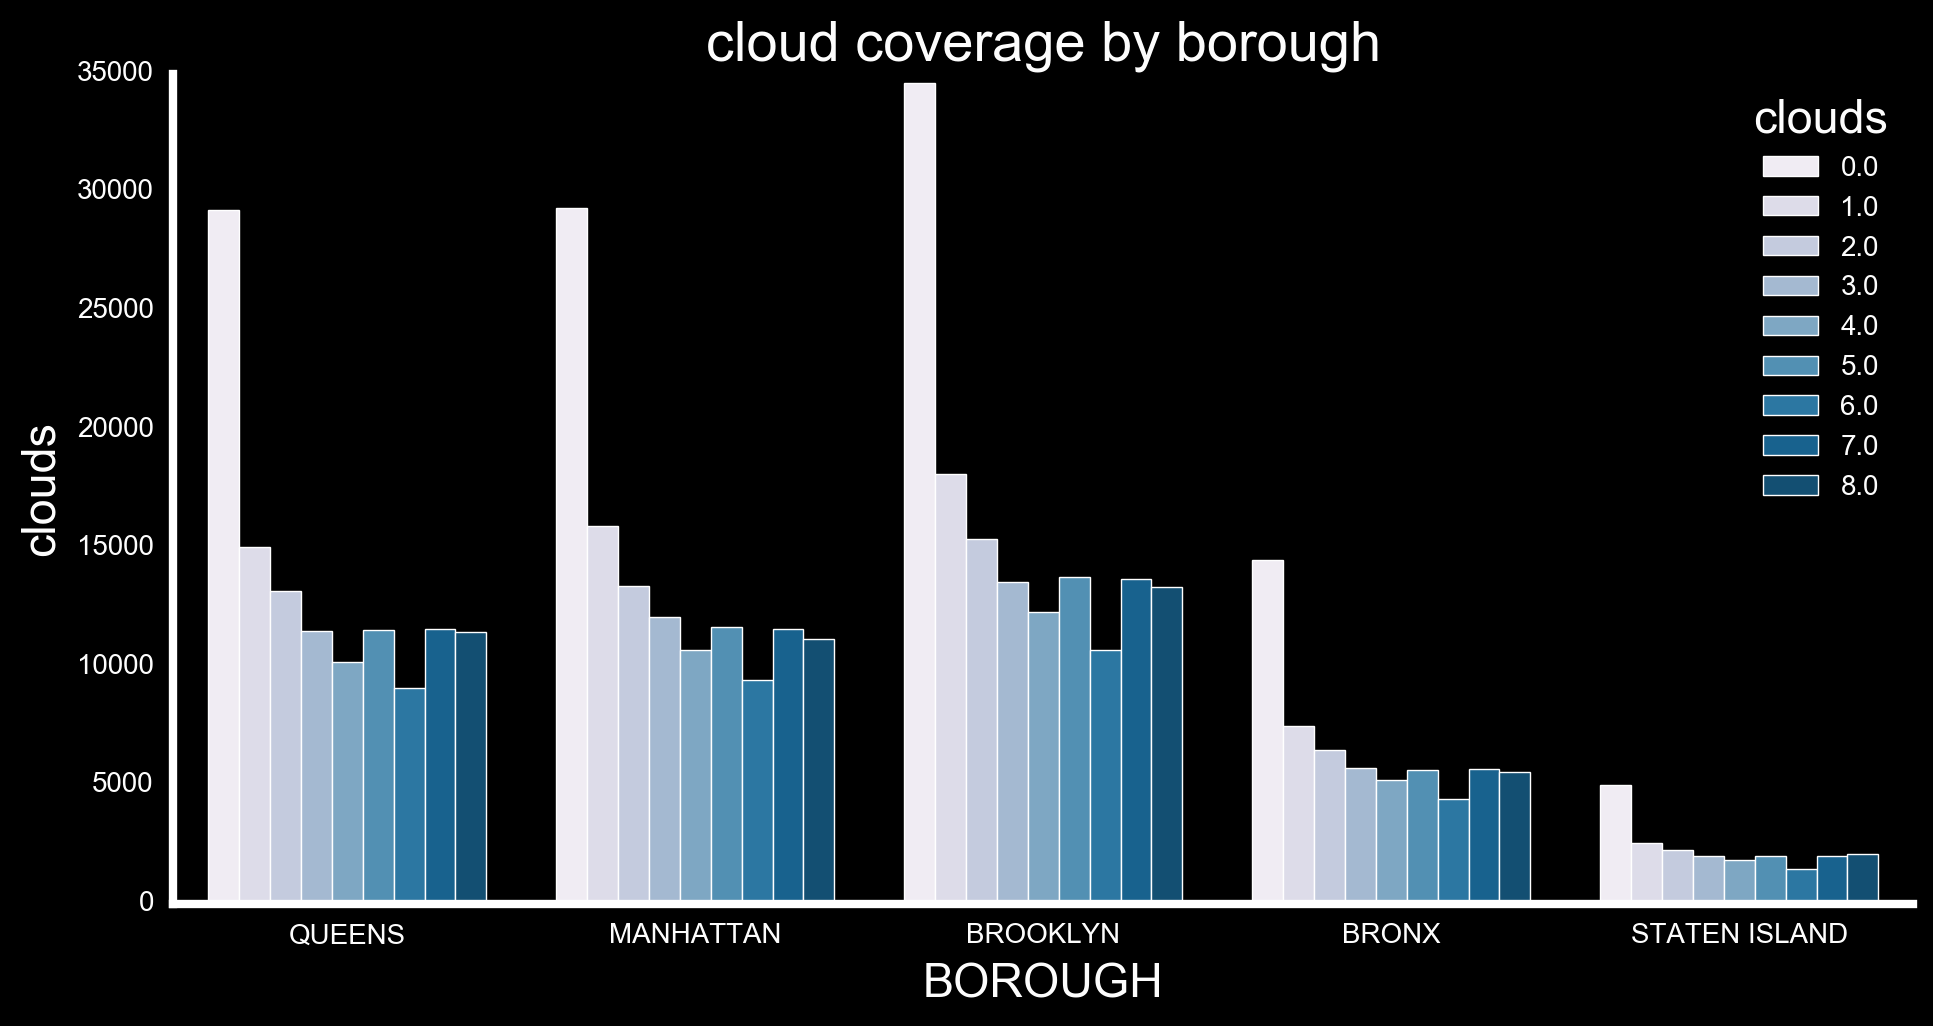

In [52]:
## Mean amount of cloud coverage per borough
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x='BOROUGH', data=NY_merged_samp, hue='clouds', palette='PuBu')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_ylabel('clouds')
ax.set_title('cloud coverage by borough')
plt.plot();

In [53]:
manhattan_df = NY_merged_samp[NY_merged_samp['BOROUGH'] == 'MANHATTAN']
brooklyn_df = NY_merged_samp[NY_merged_samp['BOROUGH'] == 'BROOKLYN']
staten_df = NY_merged_samp[NY_merged_samp['BOROUGH'] == 'STATEN ISLAND']
queens_df = NY_merged_samp[NY_merged_samp['BOROUGH'] == 'QUEENS']
bronx_df = NY_merged_samp[NY_merged_samp['BOROUGH'] == 'BRONX']

In [54]:
NY_folium_df = NY_merged_samp
NY_folium_df.rename(columns={'BOROUGH':'BoroughName'}, inplace=True)
NY_folium_df['Borough_folium'] = NY_folium_df['BoroughName'].map(lambda x: x.title())
NY_folium_df_group = NY_folium_df.groupby(['Borough_folium'])['injuries'].sum()
NY_folium_df_group

Borough_folium
Bronx            1014
Brooklyn         4460
Manhattan        3475
Queens           2199
Staten Island     104
Name: injuries, dtype: int64

In [55]:
visible_mask= NY_mask[NY_mask['min_visible'] < 10]

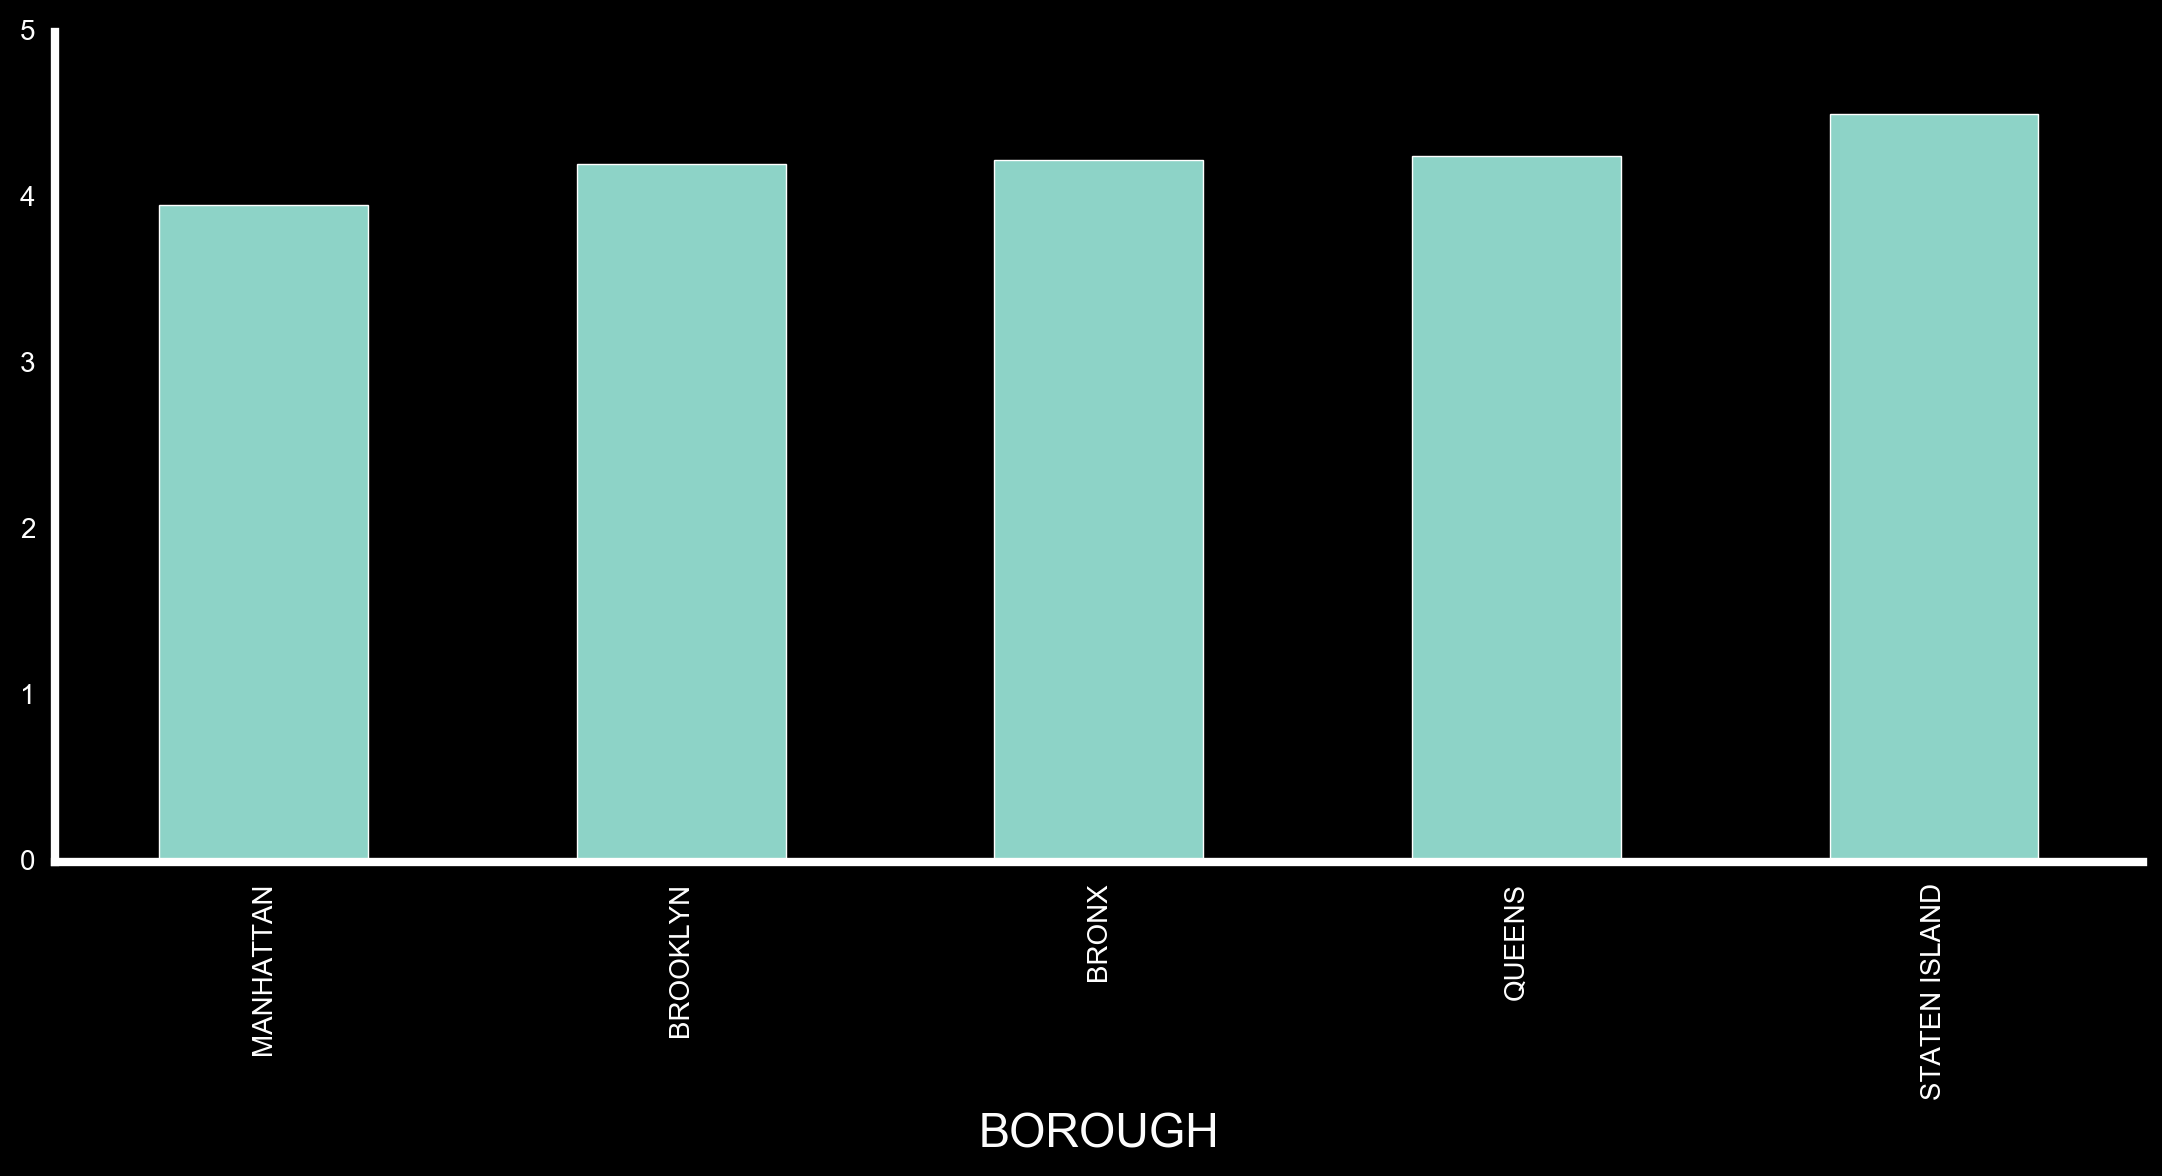

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
visible_mask.groupby(['BOROUGH'])['min_visible'].mean().sort_values().plot(kind='bar', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
plt.plot();


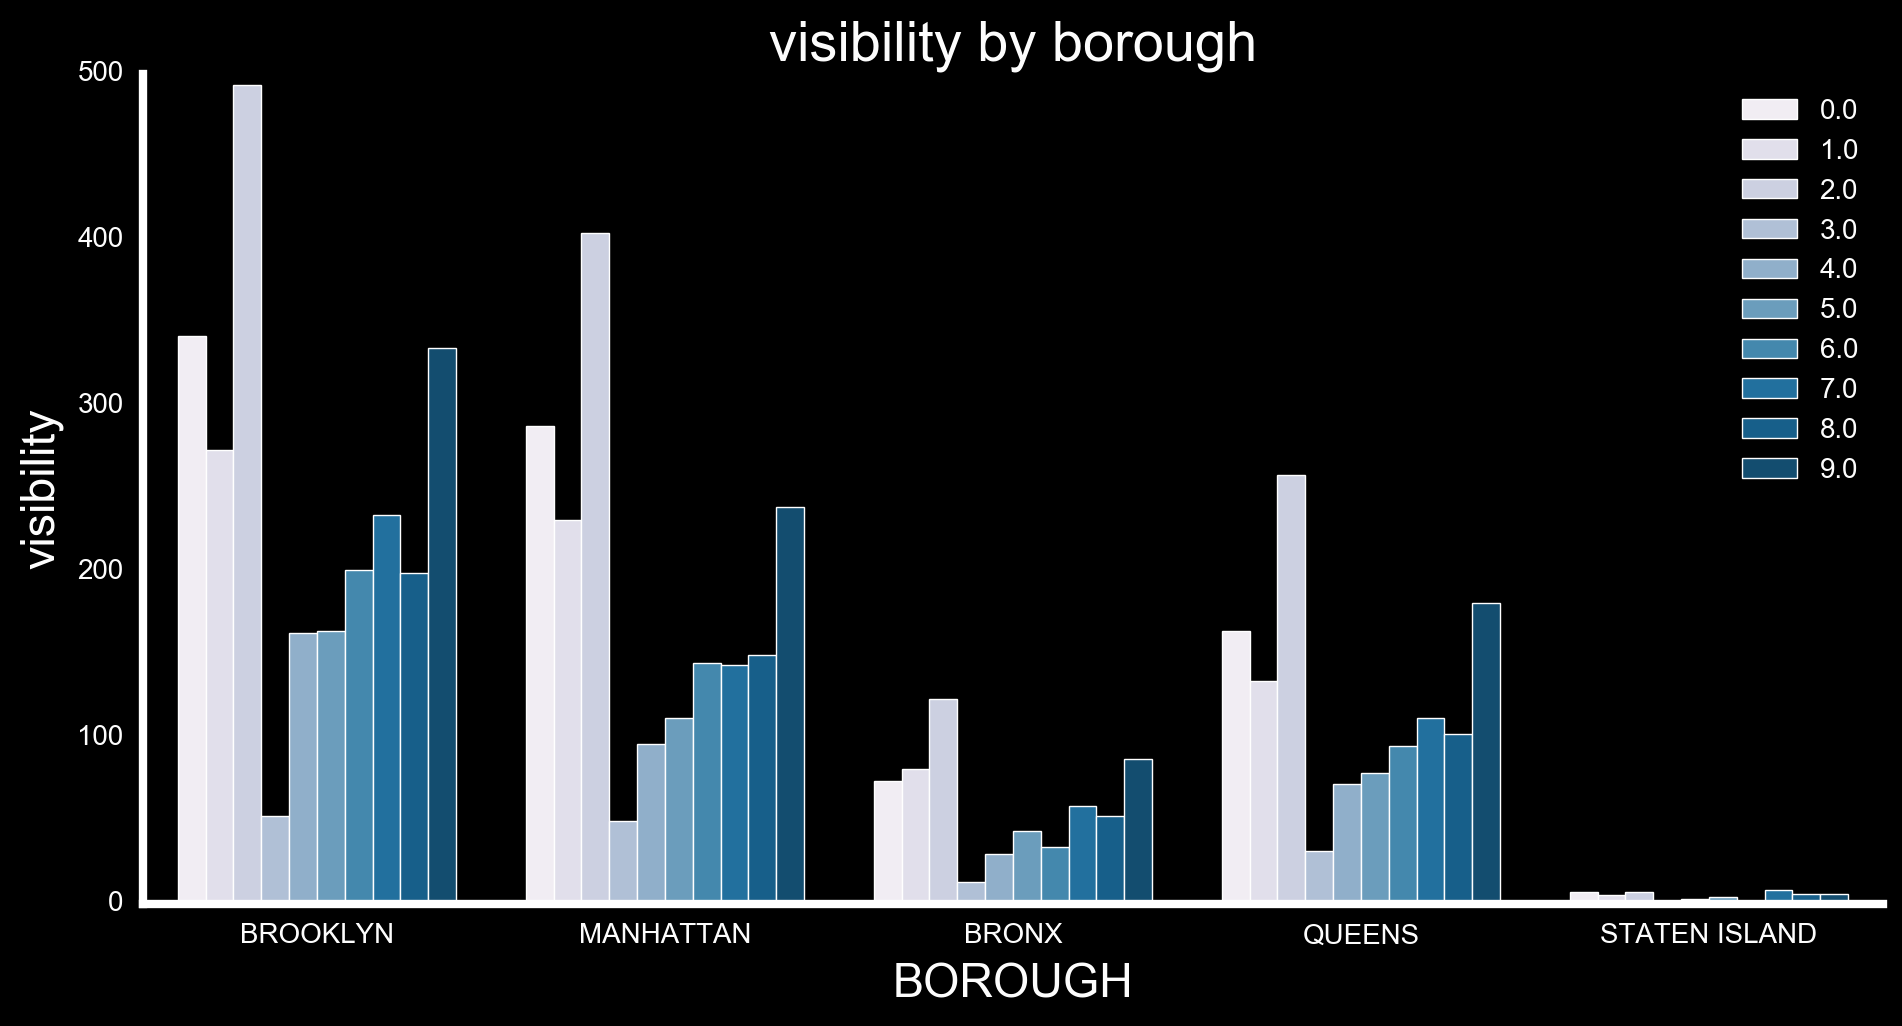

In [57]:
# Mean amount of visibility per borough
fig, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(x='BOROUGH', data=visible_mask, hue='min_visible', palette='PuBu')
ax1.grid(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_ticks_position('none')
ax1.xaxis.set_ticks_position('none')
ax1.set_ylabel('visibility')
ax1.legend(loc='upper right')
ax1.set_title('visibility by borough')
plt.plot();

//anaconda/envs/dsi/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


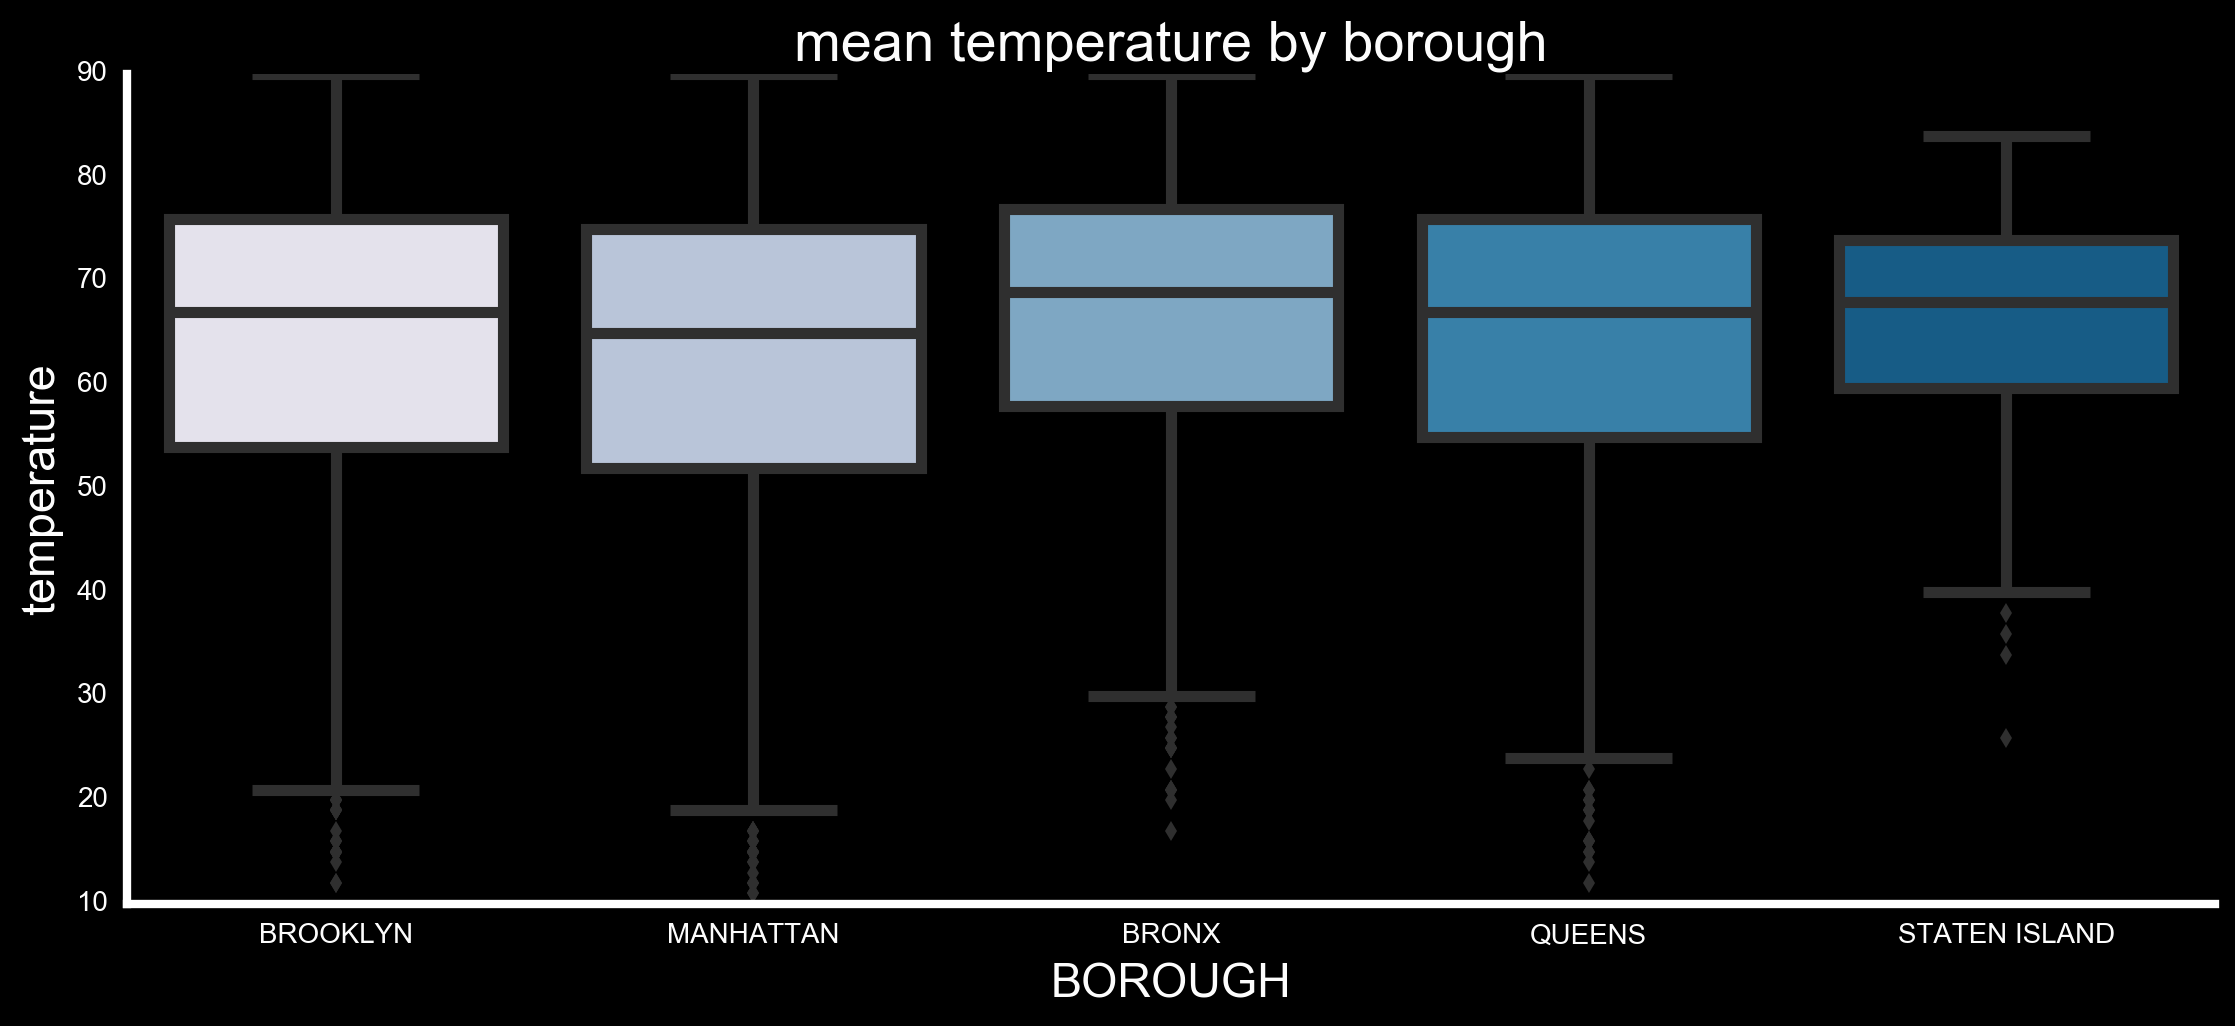

In [58]:
fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('dark_background')
sns.boxplot(x='BOROUGH',y='mean_temp',data=NY_mask, palette='PuBu')
ax.legend(loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
ax.legend(loc='lower right', title='mean temperature')
ax.set_ylabel('temperature')
ax.set_title('mean temperature by borough')
plt.plot();

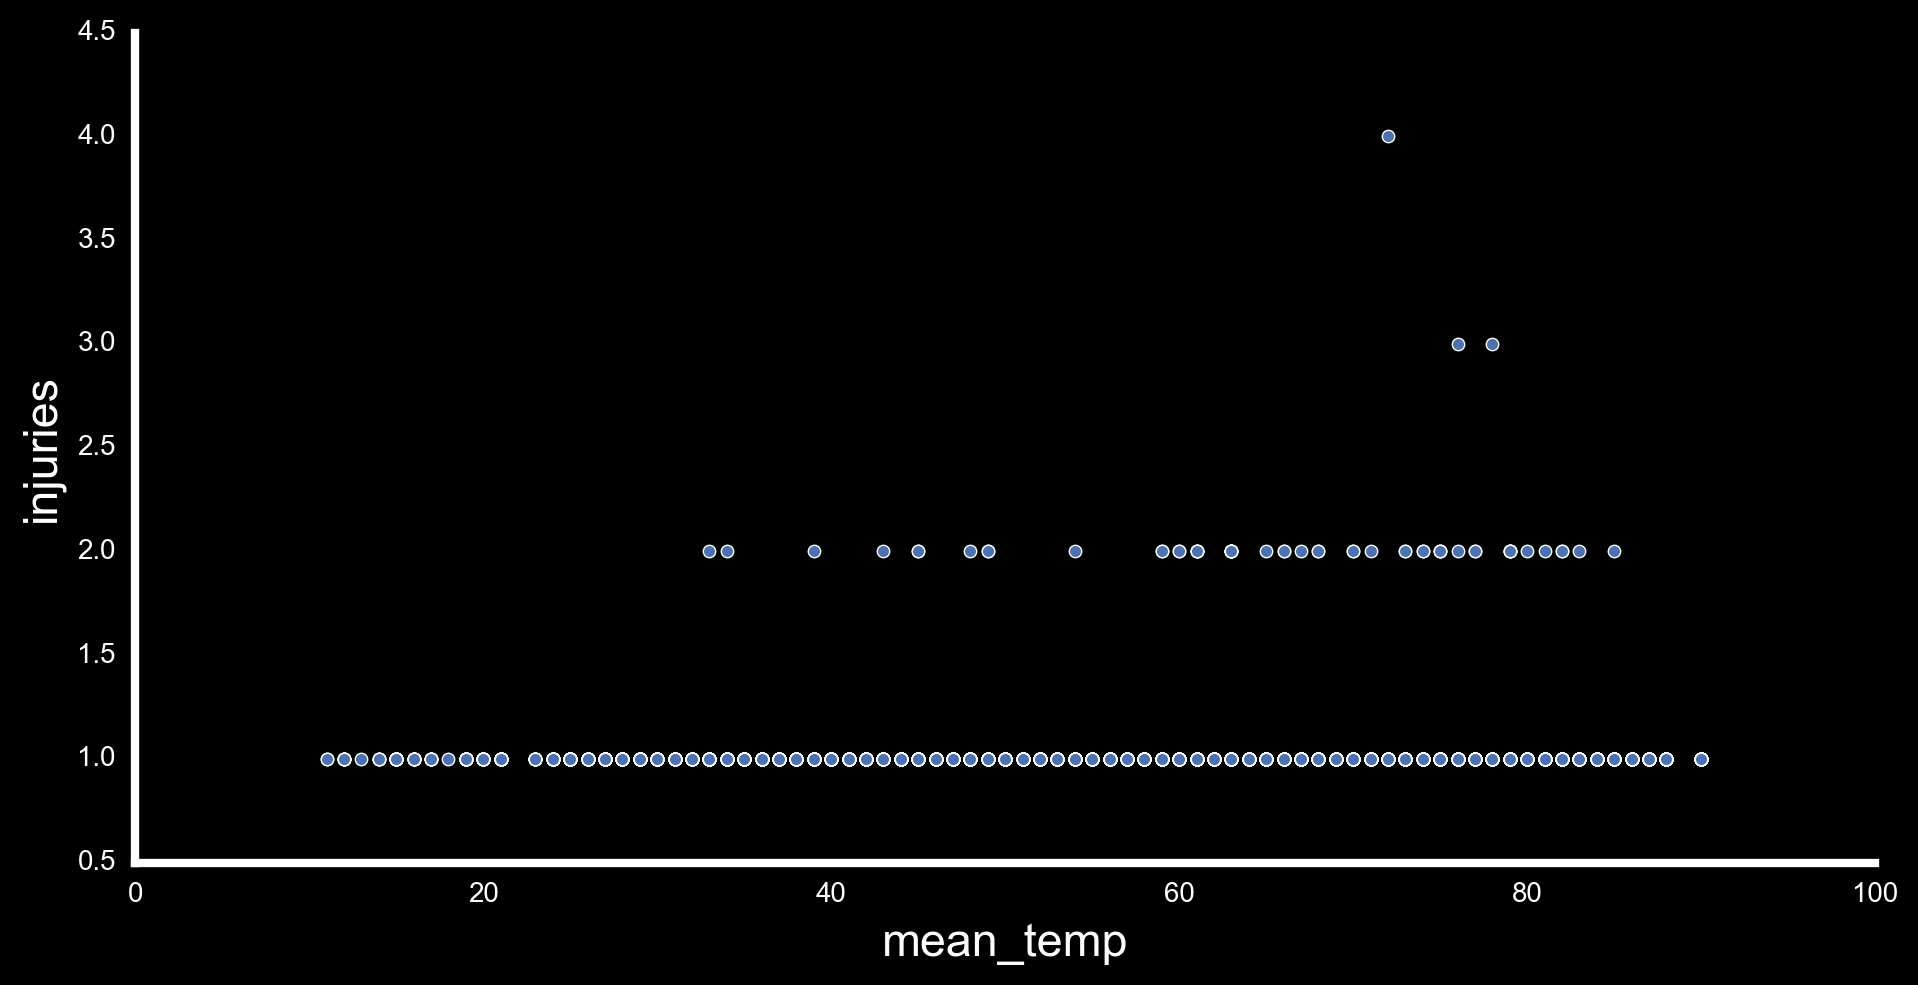

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
NY_mask.plot(kind='scatter', x='mean_temp', y='injuries', ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot();

In [63]:
rain_df = NY_merged_samp[NY_merged_samp['precip'] > 0]
rain_df = rain_df.groupby(['BoroughName','year'], as_index=False)['precip'].sum()

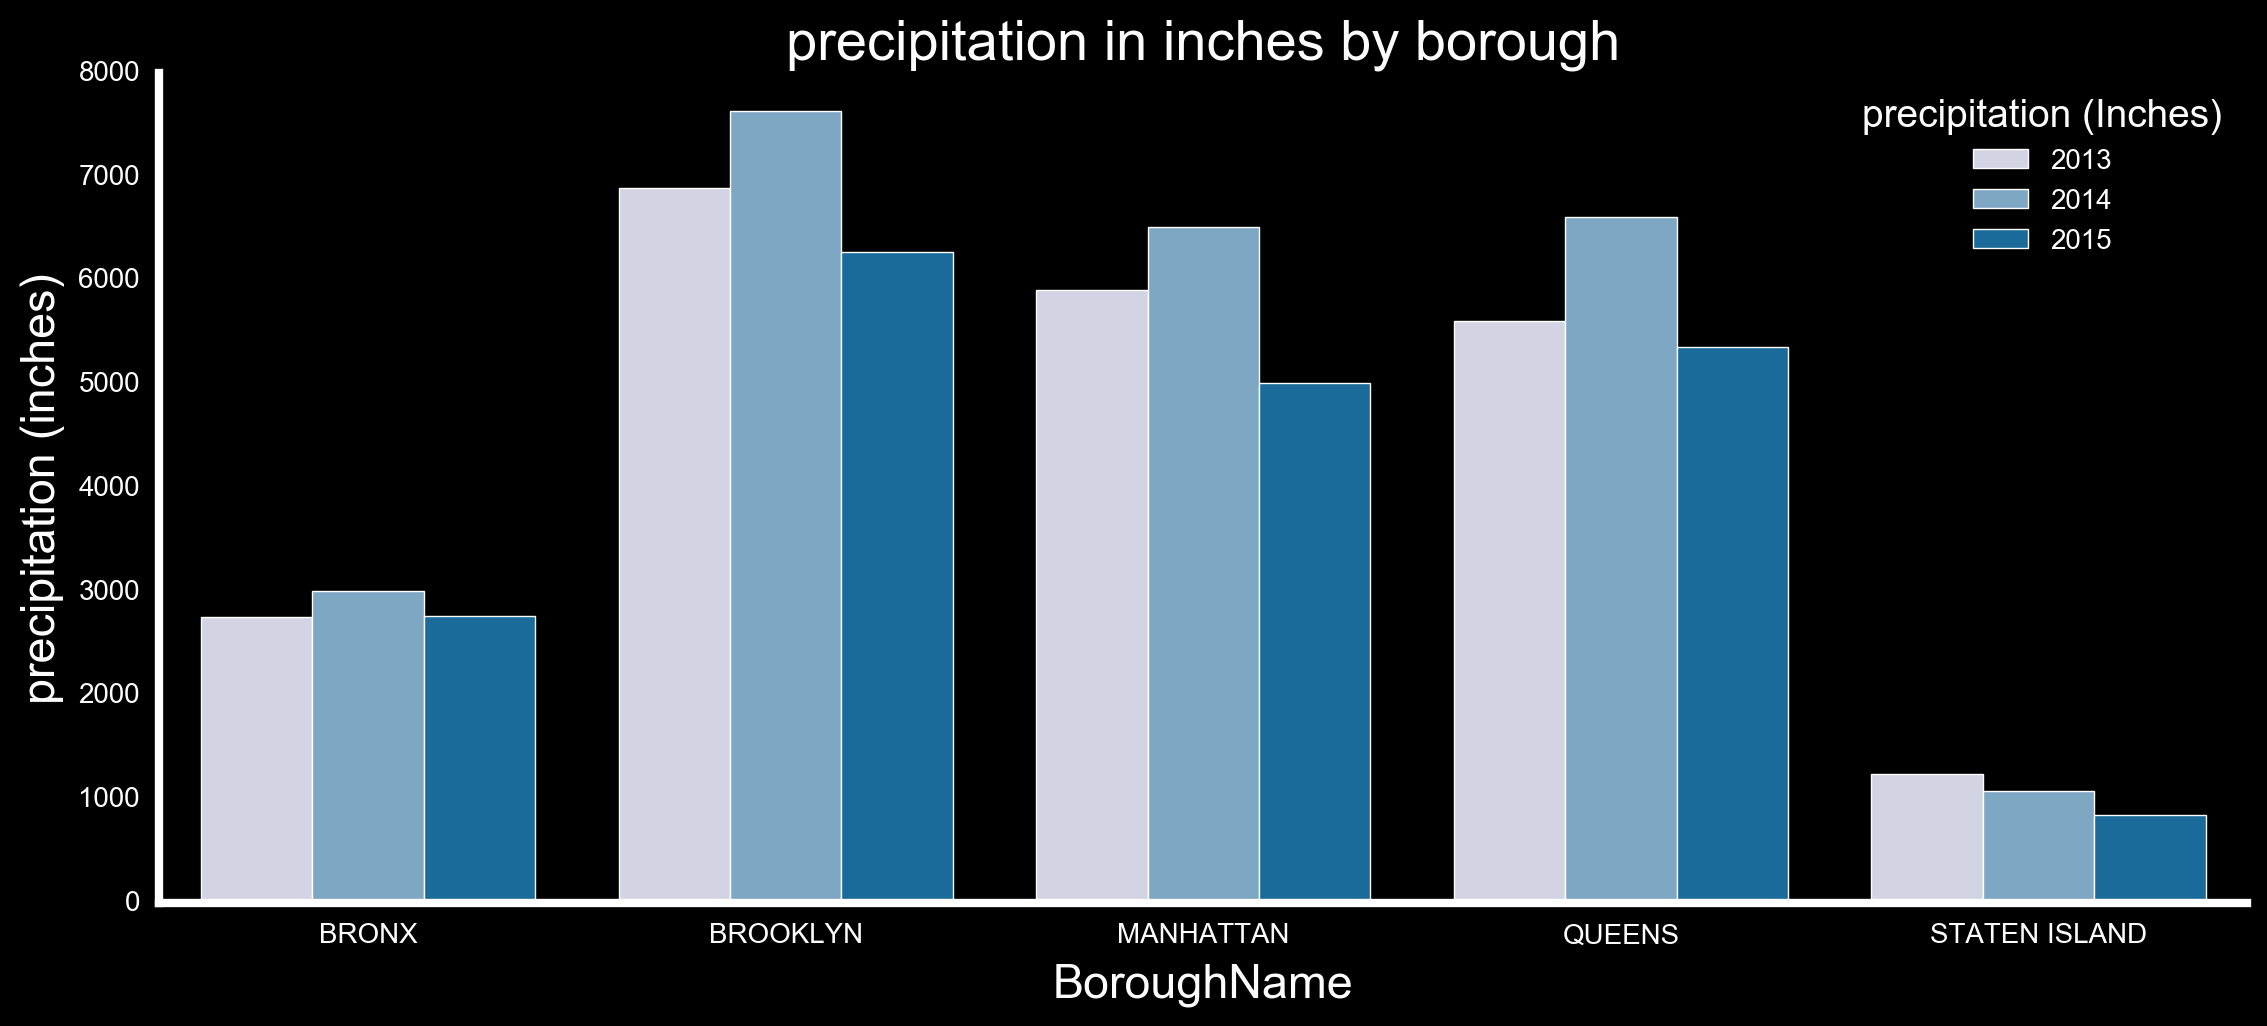

In [65]:
fig, ax = plt.subplots(figsize=(12,5))
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
sns.barplot(x='BoroughName', y='precip',data=rain_df, hue='year', palette='PuBu')
ax.set_ylabel('precipitation (inches)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.grid(False)
plt.legend(loc='upper right', title='precipitation (Inches)')
ax.set_title('precipitation in inches by borough')
plt.plot();

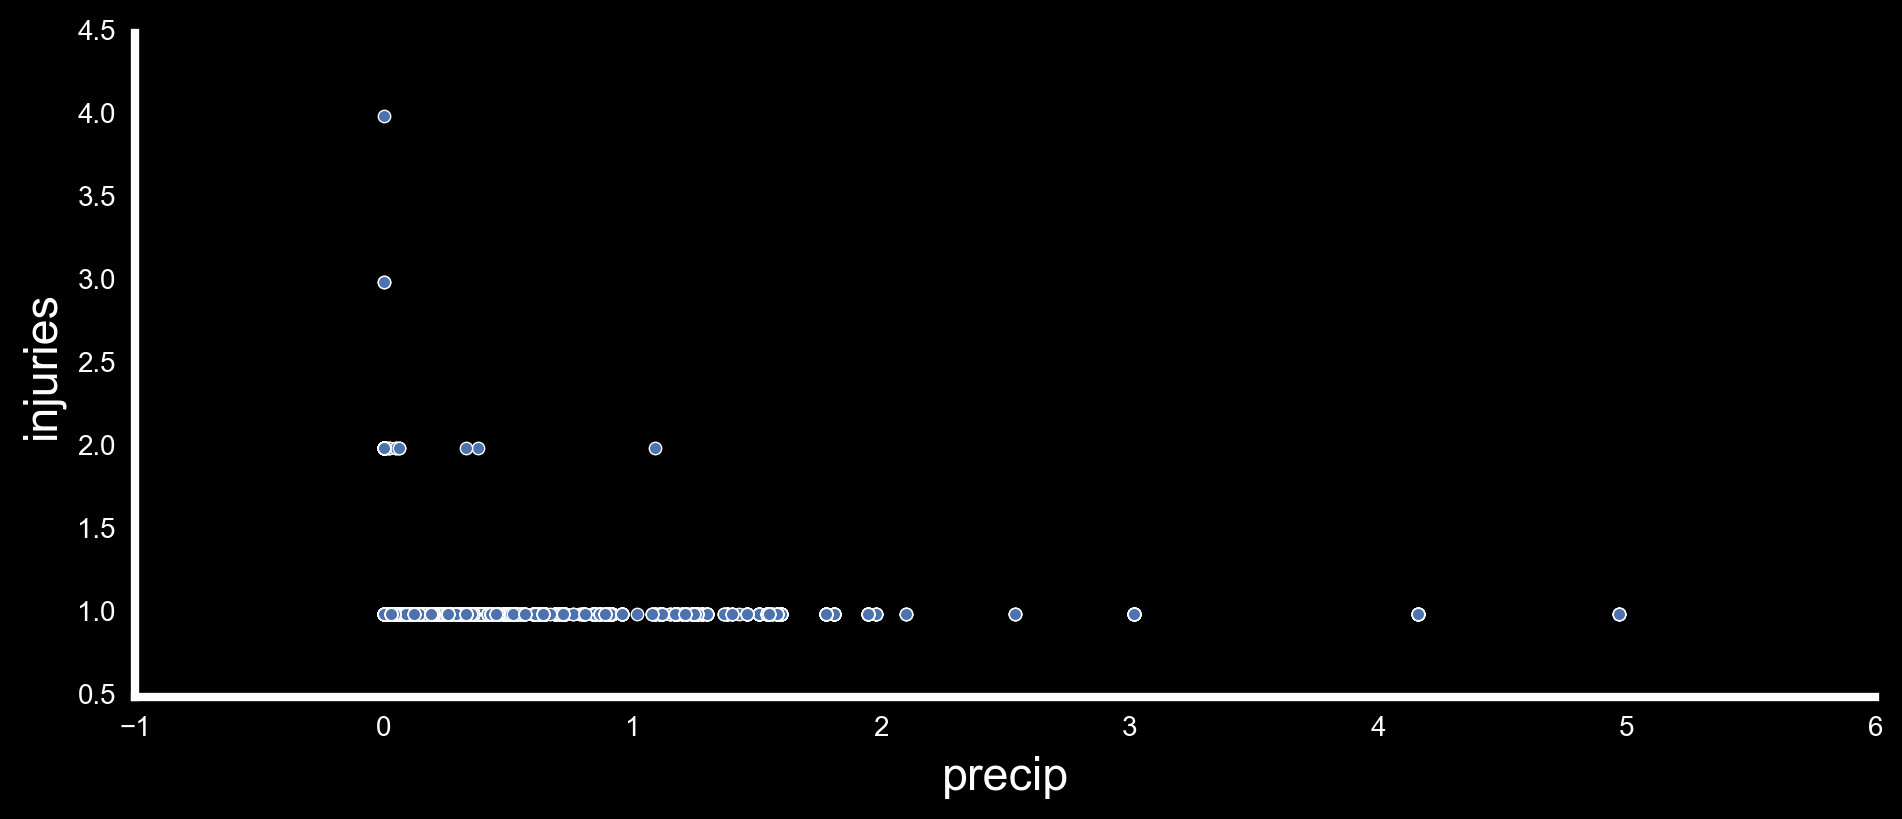

In [66]:
fig, ax = plt.subplots(figsize=(10,4))
NY_mask.plot(kind='scatter', x='precip', y='injuries', ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot();